## Thera Bank
## Credit Card Users Churn Prediction
#### Brian Hall
#### DSBA - Project 6
#### 08/5/2021

### Problem
The Thera bank recently saw a steep decline in the number of users of their credit card.  Customers leaving credit cards services would lead to bank to lose money.

### Objective
Analyze Thera banks data of customers and develop a classification model to identify those who will leave their credit card services and the reasons they may be leaving, so that the bank can improve upon those areas. 

### Recommendations 
* Account activity seems to play a critical role in identifying customers who are at risk of Attiring, finding ways to incite customers to use their card more often could reduce churn. 
* Customers who have higher contact rates are more likely to attire, it is possible that the bank is actually identifying at risk customers earlier but are not successful in their outreach. Consider revising outreach protocols once churn customers are identified.
* The Silver card category has the lowest attrition rate, consider offering low activity Blue card customers an upgrade with incentives to use, such as rewards.
* There is no attrition for customers with total trans amounts > ~11,000 and few between 2700 and 5200, consider researching these customers further to determine the reason.
* Total_Revolving_Bal, Total_Trans_Ct are the top 2 important features in the selected model
    * Nearly all customers with a revolving balance < 500 attired, most of those have a Total transaction amount of < 3000
    * Nearly all customers with a 0 revolving balance attired
* For Months_on book, there is very high spike, nearly 25% of customers, at 36 months (3 years), consider researching why this may be so.
* Providing additional data such as purchases, type of other bank products, customer location, etc. could lead to better understanding why customers are leaving and developing strategies to target specific types of customers.


## Data    
Data has been provided via CSV file (BankChurners.csv  |  1,176k)

10,127 Observations, 21 Features, No Duplicate Rows

    
**Data Dictionary**

* CLIENTNUM: Client number. Unique identifier for the customer holding the account
* Attrition_Flag: Internal event (customer activity) variable - if the account is closed then "Attrited Customer" else "Existing Customer"
* Customer_Age: Age in Years
* Gender: Gender of the account holder
* Dependent_count: Number of dependents
* Education_Level:  Educational Qualification of the account holder - Graduate, High School, Unknown, Uneducated, College(refers to a college student), Post-Graduate, Doctorate.
* Marital_Status: Marital Status of the account holder
* Income_Category: Annual Income Category of the account holder
* Card_Category: Type of Card
* Months_on_book: Period of relationship with the bank
* Total_Relationship_Count: Total no. of products held by the customer
* Months_Inactive_12_mon: No. of months inactive in the last 12 months
* Contacts_Count_12_mon: No. of Contacts between the customer and bank in the last 12 months
* Credit_Limit: Credit Limit on the Credit Card
* Total_Revolving_Bal: The balance that carries over from one month to the next is the revolving balance
* Avg_Open_To_Buy: Open to Buy refers to the amount left on the credit card to use (Average of last 12 months)
* Total_Trans_Amt: Total Transaction Amount (Last 12 months)
* Total_Trans_Ct: Total Transaction Count (Last 12 months)
* Total_Ct_Chng_Q4_Q1: Ratio of the total transaction count in 4th quarter and the total transaction count in 1st quarter
* Total_Amt_Chng_Q4_Q1: Ratio of the total transaction amount in 4th quarter and the total transaction amount in 1st quarter
* Avg_Utilization_Ratio: Represents how much of the available credit the customer spent

## Model Observations

#### All Models performed very well on all metrics for train & validation and generalize very well
#### We choose **XGBoost Tuned** model as it performed best on all metrics for cross validation, tuned, oversampling & undersampling.  While a few models performed at 100% on recall we feel that they may not perform as well in a production environment.

#### XGBoost Tuned Test Set Scores
* **Recall - 98.4**
* Accuracy - 93.0
* Precision - 93.6
* F1 Score - 95.9

#### All models were trained with Recall as the metric

---
---

### Importing Libraries

In [1]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

from pandas_profiling import ProfileReport

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# This will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

<IPython.core.display.Javascript object>

### Retrieve & Examine Data

In [2]:
# Read in data and sample
BC_Orig = pd.read_csv("BankChurners.csv")
bc = BC_Orig.copy()
print(f"There are {bc.shape[0]} rows and {bc.shape[1]} columns.")

np.random.seed(2021)
bc.sample(n=10)

There are 10127 rows and 21 columns.


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
4508,788544108,Existing Customer,43,F,2,High School,Single,Less than $40K,Blue,37,4,3,0,6611.000,1041,5570.000,0.744,4037,74,0.682,0.157
3145,719356008,Existing Customer,39,F,3,Graduate,Single,Less than $40K,Blue,36,4,3,4,1438.300,0,1438.300,1.022,4548,69,0.917,0.000
1604,712142733,Existing Customer,37,F,3,Post-Graduate,Married,Less than $40K,Blue,26,5,3,2,1910.000,1164,746.000,0.744,2028,39,1.053,0.609
9501,789394833,Existing Customer,47,M,2,NaN,Divorced,$80K - $120K,Blue,37,1,2,2,21714.000,1969,19745.000,0.944,13270,104,0.625,0.091
4542,742778358,Existing Customer,44,M,1,Graduate,Single,$60K - $80K,Blue,37,3,1,4,16739.000,1229,15510.000,0.497,4014,69,0.568,0.073
5547,720963258,Attrited Customer,52,F,3,College,Married,Less than $40K,Blue,40,3,2,3,3474.000,0,3474.000,0.735,2675,37,0.480,0.000
6237,720270633,Attrited Customer,40,F,3,Graduate,Single,Less than $40K,Blue,36,5,3,1,1516.000,0,1516.000,0.737,2709,54,0.385,0.000
6993,805453908,Existing Customer,33,M,1,High School,Divorced,$40K - $60K,Blue,28,6,1,3,2507.000,1592,915.000,0.691,4355,79,0.837,0.635
3532,772148058,Existing Customer,45,M,3,Graduate,NaN,$80K - $120K,Blue,34,6,6,3,2210.000,759,1451.000,0.892,2755,53,0.559,0.343
8332,711298458,Attrited Customer,39,F,3,NaN,Married,Less than $40K,Blue,26,5,2,5,2190.000,0,2190.000,0.691,2338,40,0.600,0.000


<IPython.core.display.Javascript object>

#### Check Data Types & Missing Values / Duplicate Rows

In [3]:
# Examine data
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           8608 non-null   object 
 6   Marital_Status            9378 non-null   object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

<IPython.core.display.Javascript object>

In [4]:
# -- Check for missing data
def findNulls(df):
    numOfNulls = df.isnull().sum().sort_values(ascending=False)
    percentOfNulls = (df.isnull().sum() / df.isnull().count()).sort_values(
        ascending=False
    )
    missingData = pd.concat(
        [numOfNulls, percentOfNulls], axis=1, keys=["numOfNulls", "percentOfNulls"]
    )
    return missingData


print(findNulls(bc))

# -- Check for duplicate rows
print("")
print("Before Duplicate Check", bc.shape)
bcObj = bc
duplicateldfRow = bcObj[bcObj.duplicated()]
print("Duplicated Rows: ", len(duplicateldfRow))
print("")
print(duplicateldfRow)


print("")
print("After Duplicate Check", bc.shape)

                          numOfNulls  percentOfNulls
Education_Level                 1519           0.150
Marital_Status                   749           0.074
Avg_Utilization_Ratio              0           0.000
Months_on_book                     0           0.000
Attrition_Flag                     0           0.000
Customer_Age                       0           0.000
Gender                             0           0.000
Dependent_count                    0           0.000
Income_Category                    0           0.000
Card_Category                      0           0.000
Total_Relationship_Count           0           0.000
Total_Ct_Chng_Q4_Q1                0           0.000
Months_Inactive_12_mon             0           0.000
Contacts_Count_12_mon              0           0.000
Credit_Limit                       0           0.000
Total_Revolving_Bal                0           0.000
Avg_Open_To_Buy                    0           0.000
Total_Amt_Chng_Q4_Q1               0          

<IPython.core.display.Javascript object>

* 10,127 Observations
* 21 Variables
* There are 2 variables with missing values
    * Education_Level - 1519
    * Marital_Status - 749
* 6 variables require data type changes

* CLIENTNUM should be dropped 


## Data Pre-Processing

Convert to categorical

Attrition_Flag, Gender, Education_Level, Marital_Status, Income_Category, Card_Category

In [5]:
# Convert identified variables to categorical
bc = bc.astype(
    {
        "Attrition_Flag": "category",
        "Gender": "category",
        "Education_Level": "category",
        "Marital_Status": "category",
        "Income_Category": "category",
        "Card_Category": "category",
    }
)
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CLIENTNUM                 10127 non-null  int64   
 1   Attrition_Flag            10127 non-null  category
 2   Customer_Age              10127 non-null  int64   
 3   Gender                    10127 non-null  category
 4   Dependent_count           10127 non-null  int64   
 5   Education_Level           8608 non-null   category
 6   Marital_Status            9378 non-null   category
 7   Income_Category           10127 non-null  category
 8   Card_Category             10127 non-null  category
 9   Months_on_book            10127 non-null  int64   
 10  Total_Relationship_Count  10127 non-null  int64   
 11  Months_Inactive_12_mon    10127 non-null  int64   
 12  Contacts_Count_12_mon     10127 non-null  int64   
 13  Credit_Limit              10127 non-null  floa

<IPython.core.display.Javascript object>

In [6]:
# Dropping CLIENTNUM from the data set
bc.drop(columns=["CLIENTNUM"], inplace=True)

<IPython.core.display.Javascript object>

### Summary of Variables

In [7]:
bc.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.000,46.326,8.017,26.000,41.000,46.000,52.000,73.000
Dependent_count,10127.000,2.346,1.299,0.000,1.000,2.000,3.000,5.000
Months_on_book,10127.000,35.928,7.986,13.000,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.000,3.813,1.554,1.000,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.000,2.341,1.011,0.000,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.000,2.455,1.106,0.000,2.000,2.000,3.000,6.000
Credit_Limit,10127.000,8631.954,9088.777,1438.300,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.000,1162.814,814.987,0.000,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.000,7469.140,9090.685,3.000,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.000,0.760,0.219,0.000,0.631,0.736,0.859,3.397


<IPython.core.display.Javascript object>

* Customer_Age has a mean of 46.32 and median of 46 with a range of 26 to 73
* Dependent_count has a mean of 2.34 and a median of 2 with a range of 0 to 5
* Months_on_book has a mean of 36 and a median of 36 with a range of 13 to 56
    * It is interesting that no customers have a relationship less than 1 year or greater than 5 years
* Total_Relationship_Count has a mean of 3.8 and a median of 4 with a range of 1 to 6
* Months_Inactive_12_mon has a mean of 2.34 and a median of 2 with a range of 0 to 6
    * No one has been inactive for more than 6 months
* Contacts_Count_12_mon has a mean of 2.5 and a median of 2 with a range of 0 to 6
* Credit_Limit has a mean of 8632 and a median of 4549 with a range of 1438 to 34516
    * There are high outliers in Credit_Limit, we will want to examine these more closely
* Total_Revolving_Bal has a mean of 1163 and a median of 1276 with a range of 0 to 2517
    * It is interesting that there are not higher revolving balances given the high values on some of the credit limits
* Avg_Open_To_Buy has a mean of 7469 and a median of 3474 with a range of 3 to 34516
    * The highest value here matches the upper credit limit outliers, which may mean that there is no activity or these could be entry errors
* Total_Trans_Amt has a mean of 4404 and median of 3899 with a range of 510 to 18484
* Total_Amt_Chng_Q4_Q1 has a mean of 0.76 and a median of 0.73 with a range of 0 to 3.397
* Total_Trans_Ct has a mean of 64.85 and a median of 67 with a range of 10 to 139
* Total_Ct_Chng_Q4_Q1 has a mean of 0.712 and a median of 0.702 with a range of 0 to 3.714
* Avg_Utilization_Ratio has a mean of 0.275 and a median of 0.176 with a range of 0 to 0.999

In [8]:
bc.describe(include="category").T

,count,unique,top,freq
Attrition_Flag,10127,2,Existing Customer,8500
Gender,10127,2,F,5358
Education_Level,8608,6,Graduate,3128
Marital_Status,9378,3,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436


<IPython.core.display.Javascript object>

* Attrition_Flag is our target variable with Existing Customer being the most frequent ~ 84%
* Gender is mostly Female
* Education_Level has 6 unique categories with Graduate being the most common (one of these categories represents missing values and will need to be imputed, possibly to Unknown)
* Marital_Status has Married as the most frequent of the 3 categories
* Income_Category has 'Less than $40k' as the most frequent of the 6 categories
* Card_Category Blue is the most frequent (~93%) of the 4 card types


#### Check the number of Unique values in each variable

In [9]:
bc.nunique()

Attrition_Flag                 2
Customer_Age                  45
Gender                         2
Dependent_count                6
Education_Level                6
Marital_Status                 3
Income_Category                6
Card_Category                  4
Months_on_book                44
Total_Relationship_Count       6
Months_Inactive_12_mon         7
Contacts_Count_12_mon          7
Credit_Limit                6205
Total_Revolving_Bal         1974
Avg_Open_To_Buy             6813
Total_Amt_Chng_Q4_Q1        1158
Total_Trans_Amt             5033
Total_Trans_Ct               126
Total_Ct_Chng_Q4_Q1          830
Avg_Utilization_Ratio        964
dtype: int64

<IPython.core.display.Javascript object>

* Models may benefit from binning some of the variables, we can explore this as an option during model building

#### Explore & Impute Education_Level categories

In [10]:
# Check Education
Education_LevelU = bc.Education_Level.unique()
print("Number of unique values in Gender: ", len(Education_LevelU))
bc.Education_Level.value_counts(dropna=False)

Number of unique values in Gender:  7


Graduate         3128
High School      2013
NaN              1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

<IPython.core.display.Javascript object>

* There are 1519 missing values ~ 14%, we will replace these with Unknown 

In [11]:
# Replace NaN with Unknown in Education_Level
bc["Education_Level"] = bc["Education_Level"].cat.add_categories("Unknown")
bc["Education_Level"] = bc["Education_Level"].fillna("Unknown")

<IPython.core.display.Javascript object>

In [12]:
# Check Education
Education_LevelU = bc.Education_Level.unique()
print("Number of unique values in Gender: ", len(Education_LevelU))
bc.Education_Level.value_counts(dropna=False)

Number of unique values in Gender:  7


Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

<IPython.core.display.Javascript object>

#### Explore & Impute Marital_Status categories

In [13]:
# Check Marital_Status
Marital_StatusU = bc.Marital_Status.unique()
print("Number of unique values in Marital_Status: ", len(Marital_StatusU))
bc.Marital_Status.value_counts(dropna=False)

Number of unique values in Marital_Status:  4


Married     4687
Single      3943
NaN          749
Divorced     748
Name: Marital_Status, dtype: int64

<IPython.core.display.Javascript object>

* There are 749 missing values ~ 7%.  We will replace these with Unknown

In [14]:
# Replace NaN with Unknown in Education_Level
bc["Marital_Status"] = bc["Marital_Status"].cat.add_categories("Unknown")
bc["Marital_Status"] = bc["Marital_Status"].fillna("Unknown")

<IPython.core.display.Javascript object>

In [15]:
# Check Marital_Status
Marital_StatusU = bc.Marital_Status.unique()
print("Number of unique values in Marital_Status: ", len(Marital_StatusU))
bc.Marital_Status.value_counts(dropna=False)

Number of unique values in Marital_Status:  4


Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64

<IPython.core.display.Javascript object>

# EDA & Additional Pre-Processing

In [16]:
# ProfileReport(bc)
# prof.to_file(output_file='output.html')

<IPython.core.display.Javascript object>

In [17]:
# looking at value counts for non-numeric features

num_to_display = 35
for colname in bc.dtypes[bc.dtypes == "category"].index:
    val_counts = bc[colname].value_counts(dropna=False)
    print(val_counts[:num_to_display])
    if len(val_counts) > num_to_display:
        print(f"Only displaying first {num_to_display} of {len(val_counts)} values.")
    print("\n")  # just for more space between

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64


F    5358
M    4769
Name: Gender, dtype: int64


Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64


Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64


Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: Income_Category, dtype: int64


Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64




<IPython.core.display.Javascript object>

* For out target variable Attrition_Flag, Atttrited Customer accounts for about 16% of the data and is imbalanced.  We will likely want to try Over / Under sampling to see what the outcome is on models.
* Income_Category has a category of abc.  We will want to look at this in context to understand what to do with it.

In [18]:
# Function to create histogram and boxplot for numerical attributes
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color="violet")
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.distplot(feature, kde=False, ax=ax_hist2)
    ax_hist2.axvline(np.mean(feature), color="green", linestyle="--")
    ax_hist2.axvline(np.median(feature), color="black", linestyle="-")


# Function to create percentages for count plots - categorical attributes
def perc_on_bar(plot, feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    """
    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=12)
    plt.show()

<IPython.core.display.Javascript object>

### Univariate Analysis

In [19]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           10127 non-null  category
 5   Marital_Status            10127 non-null  category
 6   Income_Category           10127 non-null  category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

<IPython.core.display.Javascript object>

#### Customer_Age

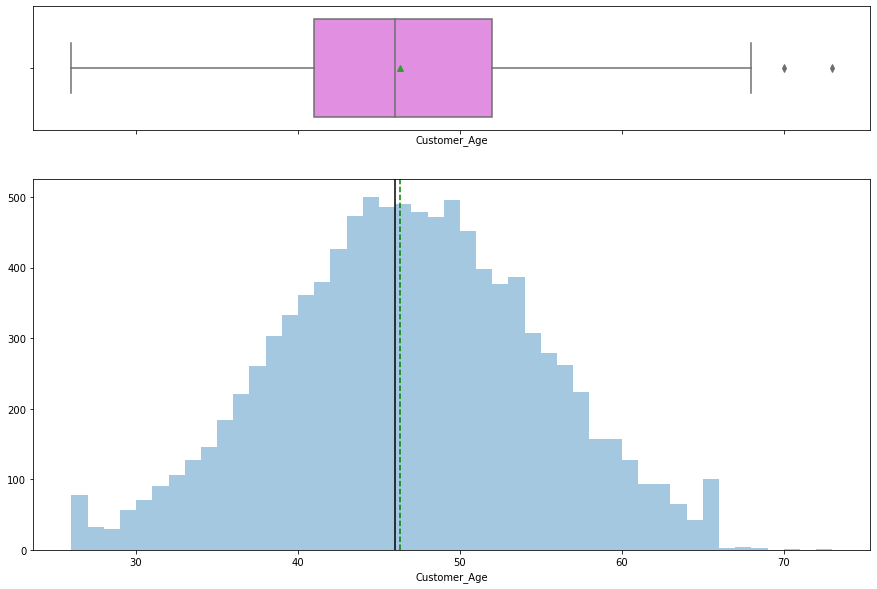

<IPython.core.display.Javascript object>

In [20]:
# Customer_Age distribution
histogram_boxplot(bc["Customer_Age"])

* Customer_Age has a normal distribution with a few high outliers

#### Dependent_Count

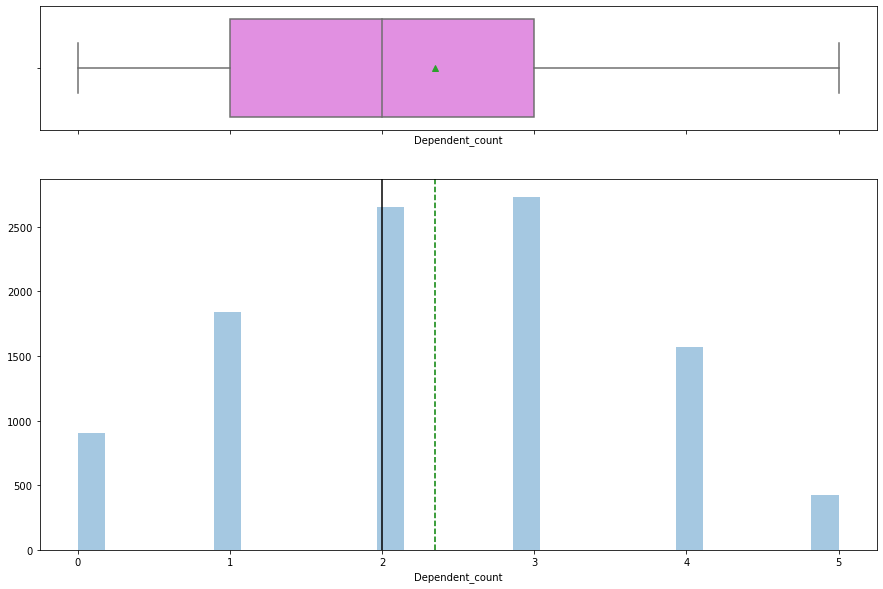

<IPython.core.display.Javascript object>

In [21]:
# Dependent_count distribution
histogram_boxplot(bc["Dependent_count"])

* Dependent_count is primarily 2 & 3 dependents

#### Months_on_book

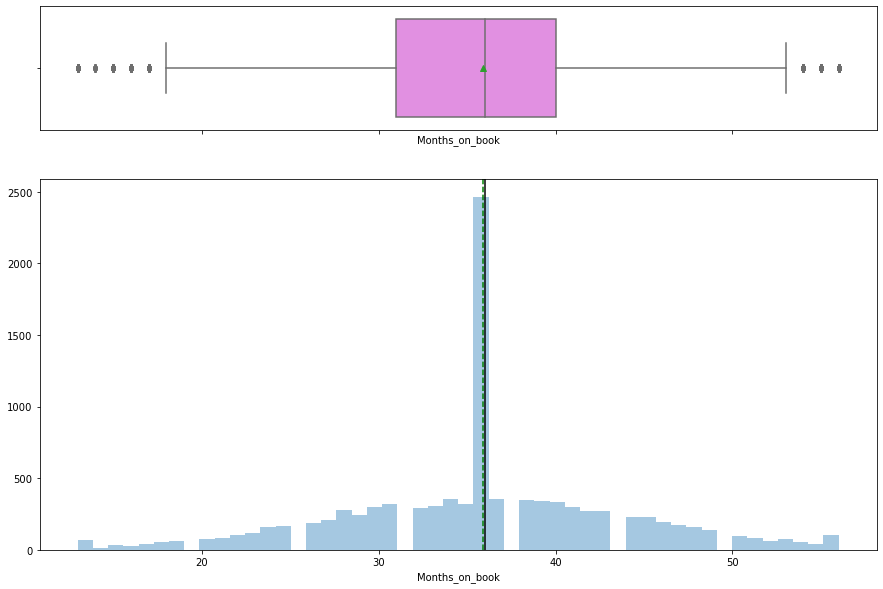

<IPython.core.display.Javascript object>

In [22]:
# Months_on_book distribution
histogram_boxplot(bc["Months_on_book"])

In [23]:
bc.Months_on_book.value_counts()

36    2463
37     358
34     353
38     347
39     341
40     333
31     318
35     317
33     305
30     300
41     297
32     289
28     275
43     273
42     271
29     241
44     230
45     227
27     206
46     197
26     186
47     171
25     165
48     162
24     160
49     141
23     116
22     105
56     103
50      96
21      83
51      80
53      78
20      74
13      70
19      63
52      62
18      58
54      53
55      42
17      39
15      34
16      29
14      16
Name: Months_on_book, dtype: int64

<IPython.core.display.Javascript object>

* There is very high spike, nearly 25% of customers, at 36 months.  This spike at 3 years is surprising, no imputation has been performed on this variable and we have no real explanation for it.  The remaining distribution is fairly normal.  We will want to examine this more closely during multi-variate analysis.

#### Total_Relationship_Count

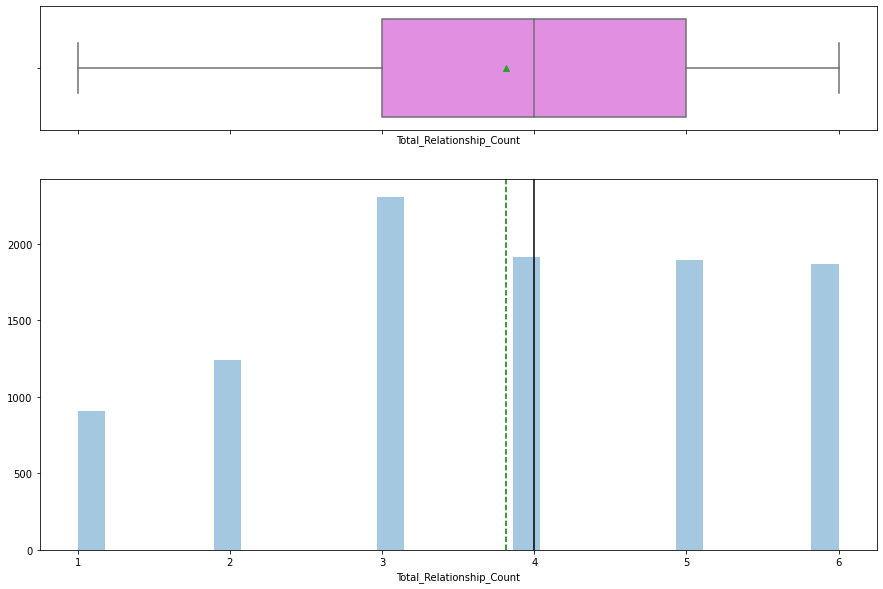

<IPython.core.display.Javascript object>

In [24]:
# Total_Relationship_Count distribution
histogram_boxplot(bc["Total_Relationship_Count"])

* The majority of customers have 3 or more products with the bank with 4,5 & 6 accounting for ~ 56%

#### Months_Inactive_12_mon

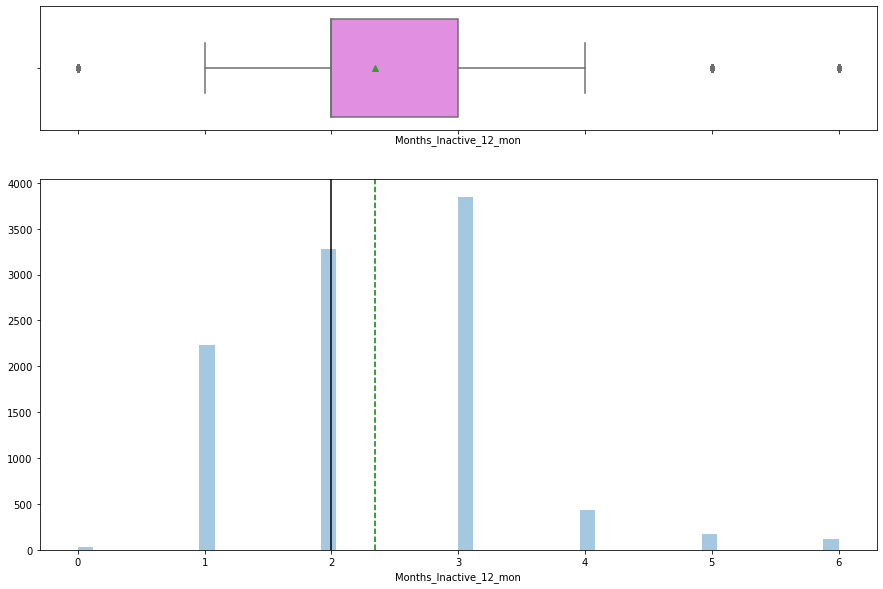

<IPython.core.display.Javascript object>

In [25]:
# Months_Inactive_12_mon distribution
histogram_boxplot(bc["Months_Inactive_12_mon"])

* Over the last 12 months most customers have had at least 1 month of inactivity with the majority having 3 months.  Only 0.02% have not had inactivity in the last 12 months.  It is unclear if this is inactivity for a consecutive amount of time or cumulative over 1 year.

#### Contacts_Count_12_mon

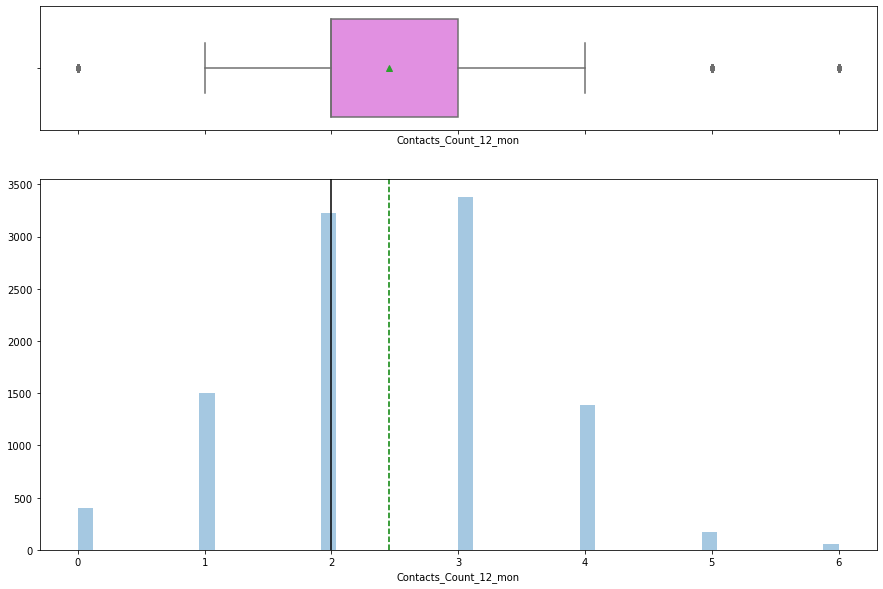

<IPython.core.display.Javascript object>

In [26]:
# Contacts_Count_12_mon distribution
histogram_boxplot(bc["Contacts_Count_12_mon"])

* Most customers have had 2 or 3 contacts with the bank in the last year, with very few having 6

#### Credit_Limit

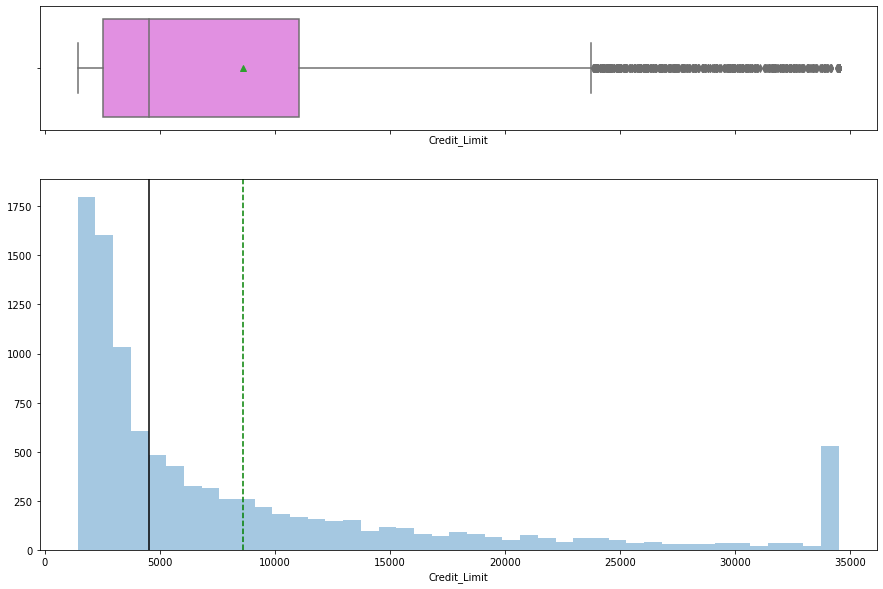

<IPython.core.display.Javascript object>

In [27]:
# Credit_Limit distribution
histogram_boxplot(bc["Credit_Limit"])

* Credit_Limit has many outliers above ~ 25,000 with a spike at 34,516 (5%).  Given the large number at this maximum it is possible that these correspond to a certain card or customer type.  The number 34516 seems odd as a cap, however we will need to investigate this further in multi-variate analysis to see if there is a pattern and determine if there should be any outlier treatment.

In [28]:
bc.Credit_Limit.value_counts()

34516.000    508
1438.300     507
15987.000     18
9959.000      18
23981.000     12
            ... 
3891.000       1
19354.000      1
34427.000      1
14527.000      1
8206.000       1
Name: Credit_Limit, Length: 6205, dtype: int64

<IPython.core.display.Javascript object>

#### Total_Revolving_Bal

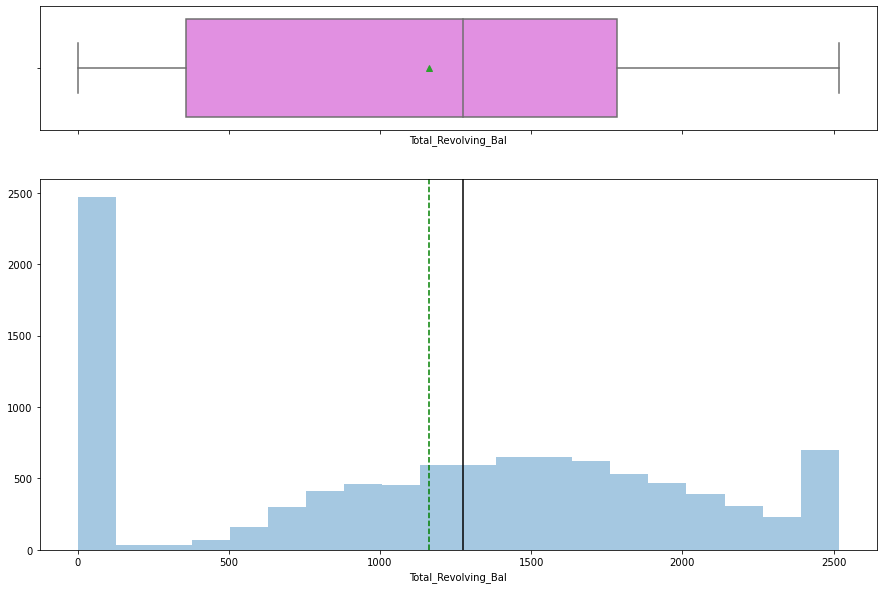

<IPython.core.display.Javascript object>

In [29]:
# Total_Revolving_Bal distribution
histogram_boxplot(bc["Total_Revolving_Bal"])

* Nearly 25% of customers do not carry a revolving balance with the majority having between 1000 and 2000.  There is a spike at 2517 of 508 customers, this is the same number of customers with a very high credit limit, we will need to see if there is a pattern to these customers.  

In [30]:
bc.Total_Revolving_Bal.value_counts()

0       2470
2517     508
1965      12
1480      12
1720      11
        ... 
1401       1
2293       1
2172       1
2040       1
204        1
Name: Total_Revolving_Bal, Length: 1974, dtype: int64

<IPython.core.display.Javascript object>

#### Avg_Open_To_Buy

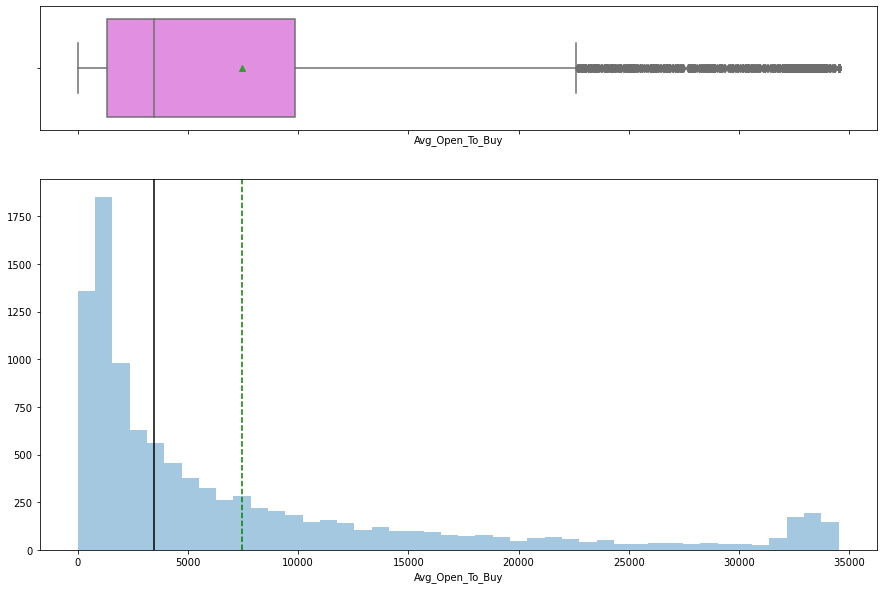

<IPython.core.display.Javascript object>

In [31]:
# Avg_Open_To_Buy distribution
histogram_boxplot(bc["Avg_Open_To_Buy"])

In [32]:
bc.Avg_Open_To_Buy.value_counts()

1438.300     324
34516.000     98
31999.000     26
787.000        8
953.000        7
            ... 
2214.000       1
4458.000       1
8013.000       1
33398.000      1
4117.000       1
Name: Avg_Open_To_Buy, Length: 6813, dtype: int64

<IPython.core.display.Javascript object>

* The majority of customers have < 5000 open credit throughout the year, and several with > ~ 33,000.

#### Total_Amt_Chng_Q4_Q1

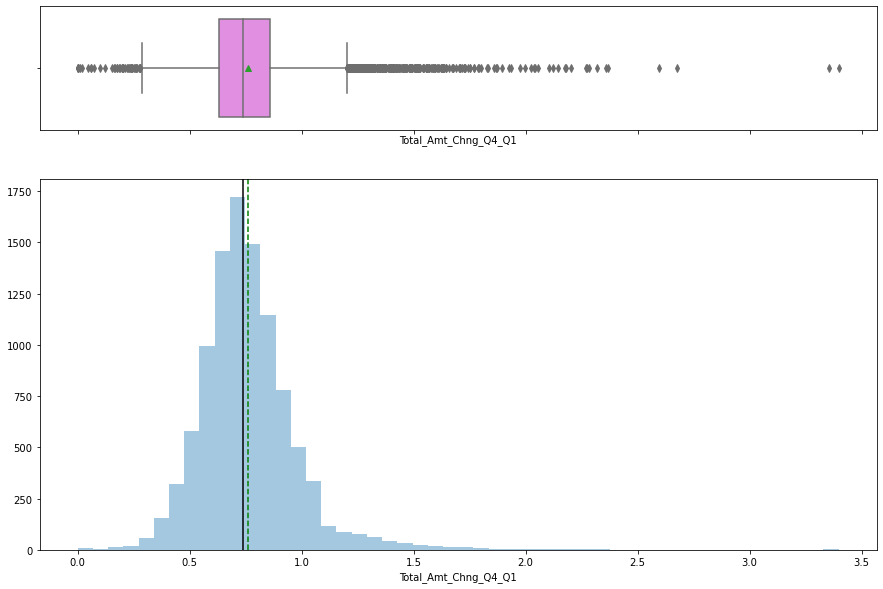

<IPython.core.display.Javascript object>

In [33]:
# Total_Amt_Chng_Q4_Q1 distribution
histogram_boxplot(bc["Total_Amt_Chng_Q4_Q1"])

In [34]:
bc[bc["Total_Amt_Chng_Q4_Q1"] > 2]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000,0,3418.000,2.594,1887,20,2.333,0.000
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.000,0,4716.000,2.175,816,28,2.500,0.000
7,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,2,2,2,29081.000,1396,27685.000,2.204,1538,36,0.714,0.048
8,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,5,2,0,22352.000,2517,19835.000,3.355,1350,24,1.182,0.113
12,Existing Customer,56,M,1,College,Single,$80K - $120K,Blue,36,3,6,0,11751.000,0,11751.000,3.397,1539,17,3.250,0.000
46,Existing Customer,56,M,2,Doctorate,Married,$60K - $80K,Blue,45,6,2,0,2283.000,1430,853.000,2.316,1741,27,0.588,0.626
47,Existing Customer,59,M,1,Doctorate,Married,$40K - $60K,Blue,52,3,2,2,2548.000,2020,528.000,2.357,1719,27,1.700,0.793
58,Existing Customer,44,F,5,Graduate,Married,abc,Blue,35,4,1,2,6273.000,978,5295.000,2.275,1359,25,1.083,0.156
154,Existing Customer,53,F,1,College,Married,Less than $40K,Blue,47,4,2,3,2154.000,930,1224.000,2.121,1439,26,1.364,0.432
177,Existing Customer,67,F,1,Graduate,Married,Less than $40K,Blue,56,4,3,2,3006.000,2517,489.000,2.053,1661,32,1.000,0.837


<IPython.core.display.Javascript object>

* Total amount of change is highly right skewed with many outliers above 1.5 with 4 extreme above 2.5.  2 of the 4 extreme outliers have 0 revolving balance and 0 average utilization.  We will cap the outliers at 2.0 as there are only 20 customers and all are Existing Customers.

In [35]:
# Capping values at 2.0
bc["Total_Amt_Chng_Q4_Q1"].clip(upper=2.0, inplace=True)

<IPython.core.display.Javascript object>

#### Total_Trans_Amt

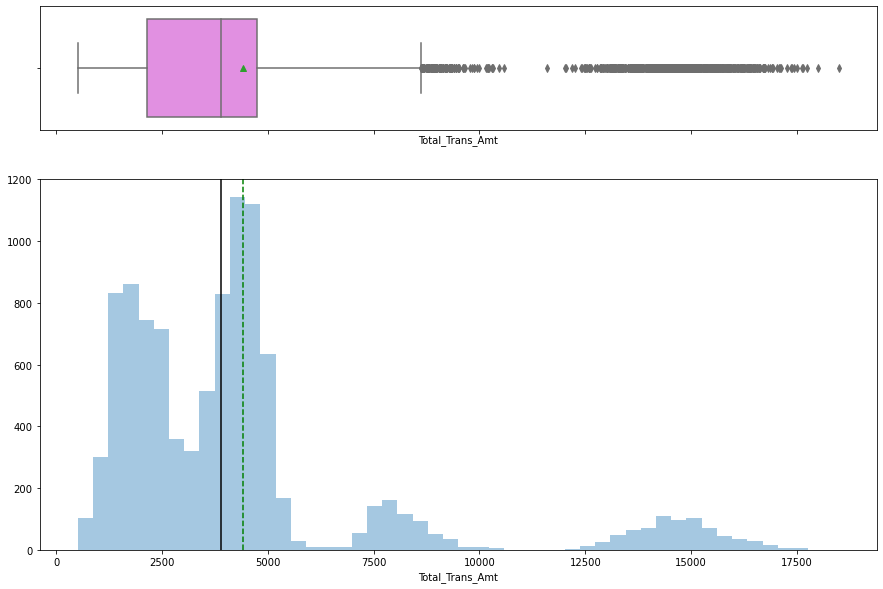

<IPython.core.display.Javascript object>

In [36]:
# Total_Trans_Amt distribution
histogram_boxplot(bc["Total_Trans_Amt"])

In [37]:
bc[bc["Total_Trans_Amt"] > 12500]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
8968,Existing Customer,50,M,1,High School,Married,Less than $40K,Blue,35,2,1,3,3968.000,2264,1704.000,1.098,12535,118,0.815,0.571
9103,Existing Customer,31,F,0,Uneducated,Divorced,Less than $40K,Silver,23,2,2,1,10850.000,1873,8977.000,0.995,13794,127,0.789,0.173
9106,Existing Customer,41,F,2,Unknown,Married,abc,Blue,21,2,3,1,14746.000,0,14746.000,0.857,14771,127,0.628,0.000
9125,Existing Customer,51,M,2,Graduate,Married,$40K - $60K,Blue,45,2,2,2,11467.000,1146,10321.000,1.018,14373,97,0.764,0.100
9128,Existing Customer,30,M,1,High School,Married,$60K - $80K,Blue,16,1,3,3,15795.000,1742,14053.000,1.022,13173,96,0.846,0.110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10116,Existing Customer,46,M,5,College,Single,$80K - $120K,Blue,36,1,2,3,13187.000,2241,10946.000,0.689,15354,112,0.931,0.170
10117,Existing Customer,57,M,2,Graduate,Married,$80K - $120K,Blue,40,6,3,4,17925.000,1909,16016.000,0.712,17498,111,0.820,0.106
10120,Existing Customer,54,M,1,High School,Single,$60K - $80K,Blue,34,5,2,0,13940.000,2109,11831.000,0.660,15577,114,0.754,0.151
10121,Existing Customer,56,F,1,Graduate,Single,Less than $40K,Blue,50,4,1,4,3688.000,606,3082.000,0.570,14596,120,0.791,0.164


<IPython.core.display.Javascript object>

* Total_Trans_Amt is highly right skewed with the majority of total transactions are between ~ 1000 and 5000.  There is an interesting "bump" of 737 outliers between 12500 and 17500. Most of these outliers have a "Blue" card and are varied on other attributes.  This could reflect a real world scenario so we will not treat them.

#### Total_Trans_Ct

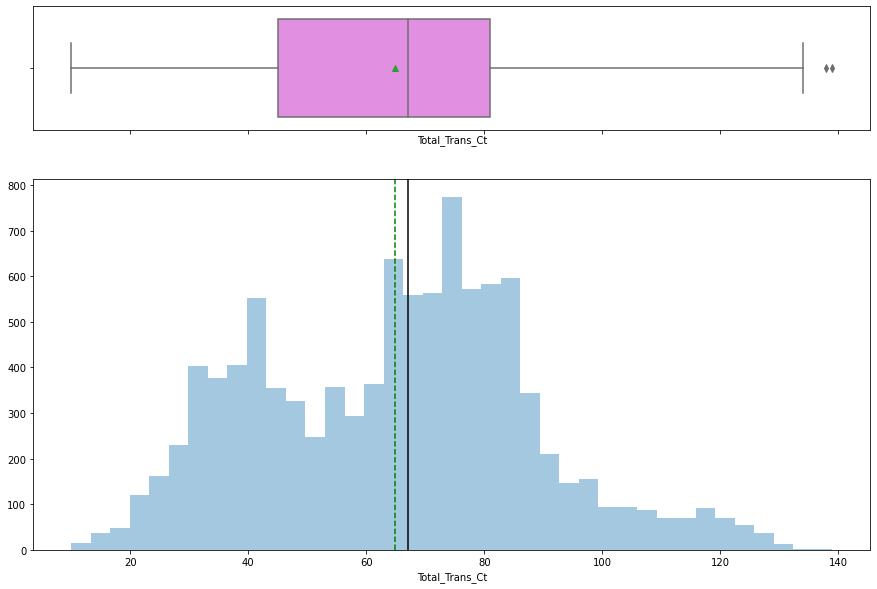

<IPython.core.display.Javascript object>

In [38]:
# Total_Trans_Ct distribution
histogram_boxplot(bc["Total_Trans_Ct"])

In [39]:
bc[bc["Total_Trans_Ct"] > 130]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
9213,Existing Customer,32,M,1,Uneducated,Single,$60K - $80K,Silver,36,2,3,1,33711.000,1437,32274.000,0.942,14880,134,0.654,0.043
9261,Existing Customer,46,F,4,Unknown,Single,Less than $40K,Blue,36,2,1,2,3973.000,0,3973.000,0.890,13740,131,0.819,0.000
9269,Existing Customer,35,M,3,High School,Married,$40K - $60K,Blue,27,1,2,3,14382.000,1950,12432.000,0.578,12941,131,0.819,0.136
9324,Existing Customer,41,M,3,Unknown,Married,$120K +,Blue,33,2,4,3,34516.000,638,33878.000,0.724,13085,139,0.675,0.018
9339,Existing Customer,27,F,0,Graduate,Unknown,Less than $40K,Blue,36,1,1,2,4548.000,1450,3098.000,0.844,14330,131,0.638,0.319
9586,Existing Customer,56,F,1,High School,Married,abc,Blue,49,1,2,1,17542.000,2517,15025.000,0.800,13939,138,0.792,0.143
9629,Existing Customer,42,M,2,Graduate,Single,$60K - $80K,Silver,36,3,3,2,34516.000,0,34516.000,0.774,12920,132,0.737,0.000
9728,Existing Customer,46,M,2,Graduate,Single,$120K +,Blue,28,1,1,1,7790.000,1921,5869.000,0.789,14567,131,0.617,0.247
9841,Existing Customer,50,M,3,Graduate,Married,$120K +,Blue,41,4,2,3,34516.000,2253,32263.000,1.032,16692,131,0.795,0.065
10085,Existing Customer,49,M,3,Uneducated,Married,$120K +,Gold,38,4,3,4,14938.000,0,14938.000,0.737,15277,131,0.724,0.000


<IPython.core.display.Javascript object>

* The majority of customers have had between 30 to 90 transactions over the last 12 months.  There are ~ 10 outliers above 130.  We will not treat these.

#### Total_Ct_Chng_Q4_Q1

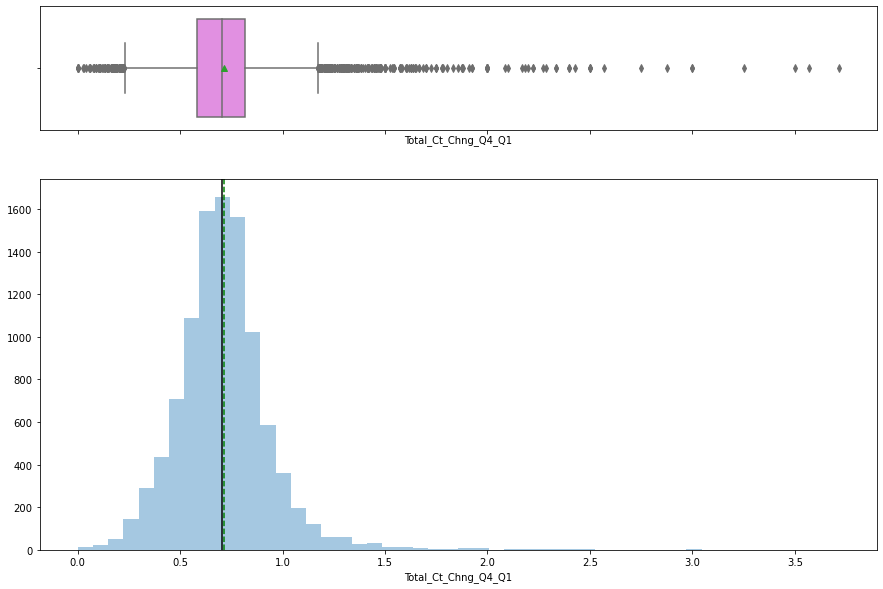

<IPython.core.display.Javascript object>

In [40]:
# Total_Trans_Ct Total_Ct_Chng_Q4_Q1
histogram_boxplot(bc["Total_Ct_Chng_Q4_Q1"])

In [41]:
bc[bc["Total_Ct_Chng_Q4_Q1"] > 2.5]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000,864,7392.000,1.541,1291,33,3.714,0.105
12,Existing Customer,56,M,1,College,Single,$80K - $120K,Blue,36,3,6,0,11751.000,0,11751.000,2.000,1539,17,3.250,0.000
30,Existing Customer,53,M,3,Unknown,Married,$80K - $120K,Blue,33,3,2,3,2753.000,1811,942.000,0.977,1038,25,2.571,0.658
113,Existing Customer,54,F,0,Uneducated,Married,Less than $40K,Blue,36,2,2,2,1494.000,706,788.000,1.674,1305,24,3.000,0.473
146,Existing Customer,41,F,2,Graduate,Single,Less than $40K,Blue,32,6,3,2,2250.000,2117,133.000,1.162,1617,31,2.875,0.941
190,Existing Customer,57,M,1,Graduate,Married,$80K - $120K,Blue,47,5,3,1,14612.000,1976,12636.000,1.768,1827,24,3.000,0.135
269,Existing Customer,54,M,5,Graduate,Married,$60K - $80K,Blue,38,3,3,3,2290.000,1434,856.000,0.923,1119,18,3.500,0.626
366,Existing Customer,36,F,4,Graduate,Married,$40K - $60K,Blue,36,6,3,3,1628.000,969,659.000,0.999,1893,15,2.750,0.595
773,Existing Customer,61,M,0,Post-Graduate,Married,abc,Blue,53,6,2,3,14434.000,1927,12507.000,2.000,1731,32,3.571,0.134


<IPython.core.display.Javascript object>

* Total change ratio from Q1 to Q4 is highly right skewed with many outliers above ~ 1.25.  We will not treat these outliers as they may account for real word scenarios.  
* The majority of customers had fewer transactions in Q4 than in Q1

#### Avg_Utilization_Ratio

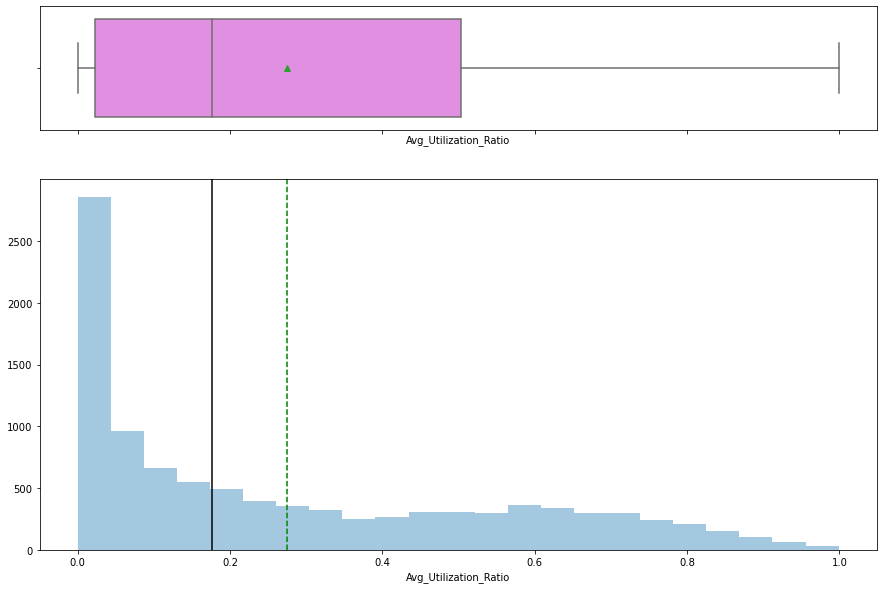

<IPython.core.display.Javascript object>

In [42]:
# Avg_Utilization_Ratio Total_Ct_Chng_Q4_Q1
histogram_boxplot(bc["Avg_Utilization_Ratio"])

* Avg_Utilization_Ratio is highly right skewed with no apparent outliers.  The mean is ~ 0.24 with the majority of customers having < ~0.05 change.

### Univariate analysis on Categorical attributes

In [43]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           10127 non-null  category
 5   Marital_Status            10127 non-null  category
 6   Income_Category           10127 non-null  category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

<IPython.core.display.Javascript object>

#### Attrition_Flag

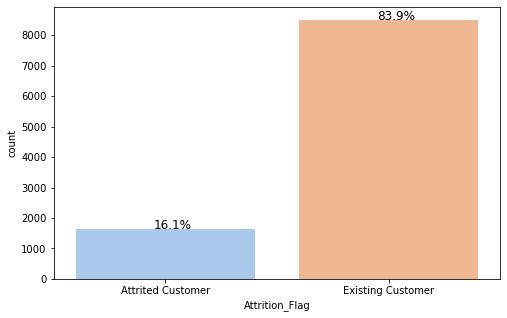

<IPython.core.display.Javascript object>

In [44]:
# plot Attrition_Flag
plt.figure(figsize=(8, 5))
ax = sns.countplot(bc["Attrition_Flag"], palette="pastel")
perc_on_bar(ax, bc["Attrition_Flag"])

* Attrition_Flag is our target variable with 16.1% of customers in the data being attrited, or account closed.
* The target variable is imbalanced.

#### Gender

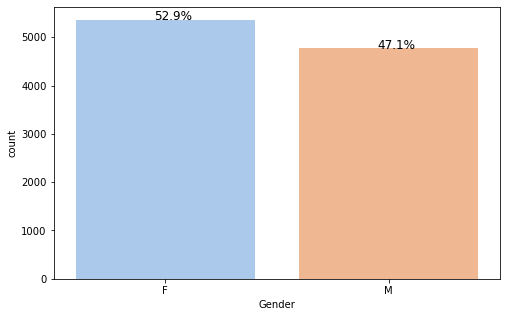

<IPython.core.display.Javascript object>

In [45]:
# plot Gender
plt.figure(figsize=(8, 5))
ax = sns.countplot(bc["Gender"], palette="pastel")
perc_on_bar(ax, bc["Gender"])

* The majority of customers ~ 53% are Female

#### Education_Level

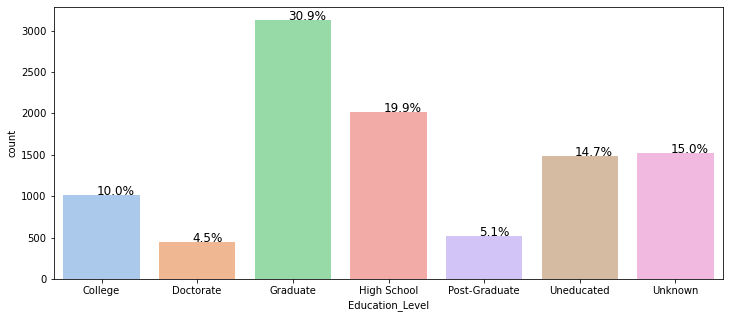

<IPython.core.display.Javascript object>

In [46]:
# plot Education_Level
plt.figure(figsize=(12, 5))
ax = sns.countplot(bc["Education_Level"], palette="pastel")
perc_on_bar(ax, bc["Education_Level"])

* The majority of customers ~ 31% are Graduate, with High School next with 20%.  There are 15% Unknown that were imputed from missing values.
* We will want to make this ordinal with Unknown being -1

#### Marital_Status

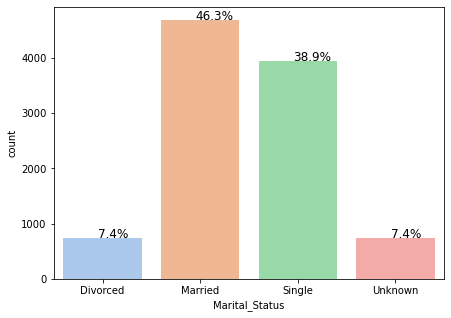

<IPython.core.display.Javascript object>

In [47]:
# plot Marital_Status
plt.figure(figsize=(7, 5))
ax = sns.countplot(bc["Marital_Status"], palette="pastel")
perc_on_bar(ax, bc["Marital_Status"])

* The majority of customers 46% are married with 39% being single.
* 7.4% of customers have a Marital_Status of Unknown, these were imputed missing values

#### Income_Category

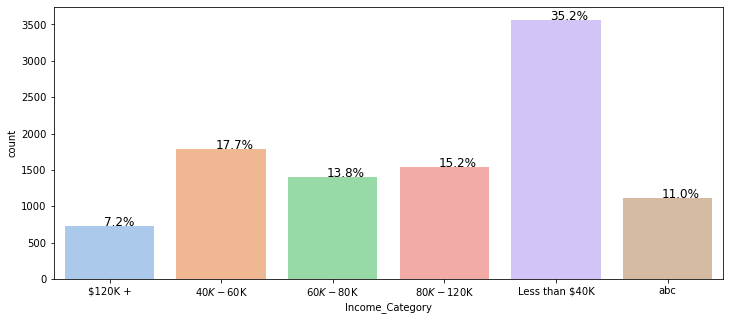

<IPython.core.display.Javascript object>

In [48]:
# plot Income_Category
plt.figure(figsize=(12, 5))
ax = sns.countplot(bc["Income_Category"], palette="pastel")
perc_on_bar(ax, bc["Income_Category"])

* The majority of customers, 35%, make less than 40k per year with 40-60, 60-80 & 80-120 being roughly equal at 15% - 17%.
* Only 7% of customers make above 120k
* A category of abc accounts for 11% of the data. This has NOT been imputed from missing values and the data dictionary gives no guidance for this category.  We will look for patterns during multi-vairate analysis to see how to treat this category.
* We will want to make Income_Category ordinal when encoding.

#### Card_Category

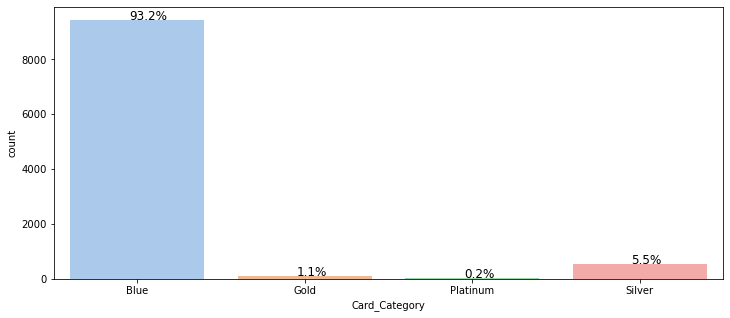

<IPython.core.display.Javascript object>

In [49]:
# plot Card_Category
plt.figure(figsize=(12, 5))
ax = sns.countplot(bc["Card_Category"], palette="pastel")
perc_on_bar(ax, bc["Card_Category"])

* The vast majority of customers have a "Blue" Card at 93%.
* Platinum card accounts for only 0.2%
* We will want to make Card_Category ordinal when encoding

### Multi-Variate Analysis

#### Encode Attrition_Flag to 0 - Attried Customer & 1 - Existing Customer 

In [50]:
# Label encode Attrition_Flag
replace_values = {"Attrited Customer": 0, "Existing Customer": 1}
bc = bc.replace({"Attrition_Flag": replace_values})

<IPython.core.display.Javascript object>

In [51]:
bc.head(10)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.000,777,11914.000,1.335,1144,42,1.625,0.061
1,1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000,864,7392.000,1.541,1291,33,3.714,0.105
2,1,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000,0,3418.000,2.000,1887,20,2.333,0.000
3,1,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.000,2517,796.000,1.405,1171,20,2.333,0.760
4,1,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.000,0,4716.000,2.000,816,28,2.500,0.000
5,1,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.000,1247,2763.000,1.376,1088,24,0.846,0.311
6,1,51,M,4,Unknown,Married,$120K +,Gold,46,6,1,3,34516.000,2264,32252.000,1.975,1330,31,0.722,0.066
7,1,32,M,0,High School,Unknown,$60K - $80K,Silver,27,2,2,2,29081.000,1396,27685.000,2.000,1538,36,0.714,0.048
8,1,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,5,2,0,22352.000,2517,19835.000,2.000,1350,24,1.182,0.113
9,1,48,M,2,Graduate,Single,$80K - $120K,Blue,36,6,3,3,11656.000,1677,9979.000,1.524,1441,32,0.882,0.144


<IPython.core.display.Javascript object>

In [52]:
# sns.pairplot(bc, hue="Attrition_Flag")

<IPython.core.display.Javascript object>

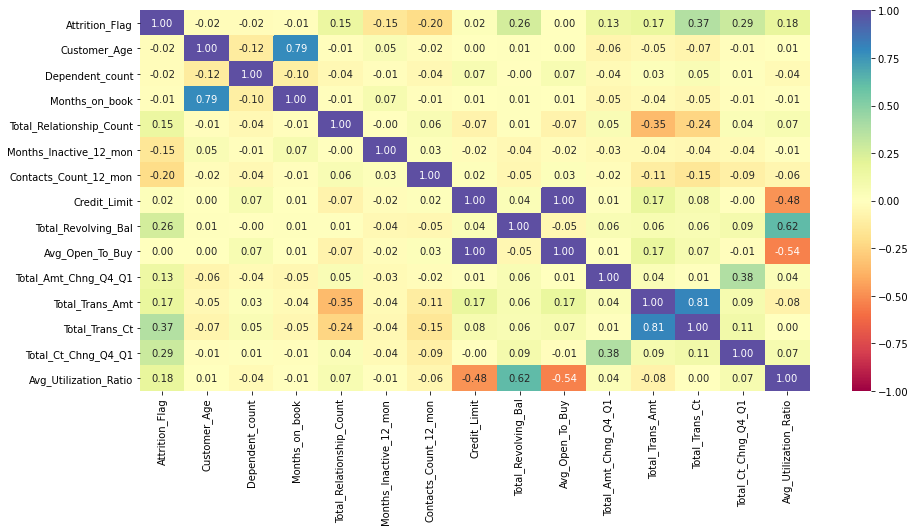

<IPython.core.display.Javascript object>

In [53]:
plt.figure(figsize=(15, 7))
sns.heatmap(bc.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

* As would be expected Credit_Limit and Avg_Open_To_Buy are perfectly correlated, we will want to drop one of these prior to modeling
* Customer_Age and Months_on_book are highly correlated at 0.79, this would normally make some sense, however the longest a customer has been with the bank is 4.6 years.
* Total_Revolving_Bal and Avg_Utilization_Ratio are moderately correlated at 0.62
* Total_Trans_Amt and Total_Trans_Ct are highly correlated at 0.81, this is not surprising, We will want to drop one of these prior to modeling
* Credit_Limit & Avg_Open_To_Buy are moderately negatively correlated with Avg_Utilization_ratio


### Exploe Target Variable - Attrition_Flag

In [54]:
## Function to plot stacked bar chart for ProductPitched
def af_stacked_plot(x):
    sns.set(palette="bright")
    tab1 = pd.crosstab(x, bc["Attrition_Flag"], margins=True)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(x, bc["Attrition_Flag"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    # plt.legend(loc='lower left', frameon=False)
    # plt.legend(loc="upper left", bbox_to_anchor=(0,1))
    plt.show()

<IPython.core.display.Javascript object>

#### Age & Attrition


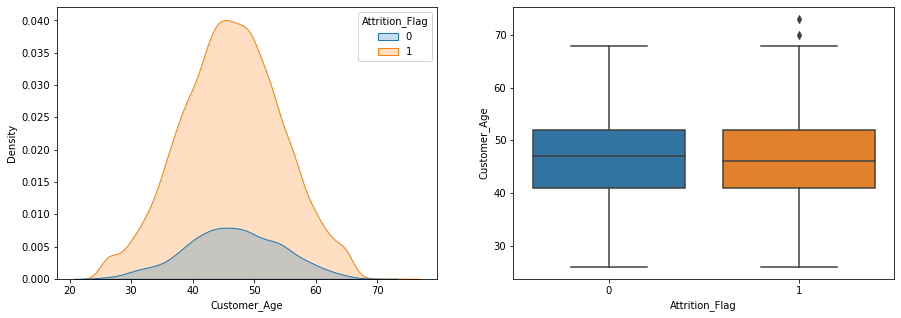

<IPython.core.display.Javascript object>

In [55]:
# ProdTaken and MonthlyIncome
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(x="Customer_Age", hue="Attrition_Flag", fill=True, data=bc, ax=ax[0])
sns.boxplot(x="Attrition_Flag", y="Customer_Age", data=bc, ax=ax[1])
fig.show()

* Age seems to have little impact on Attrition

#### Months_on_book and Attrition

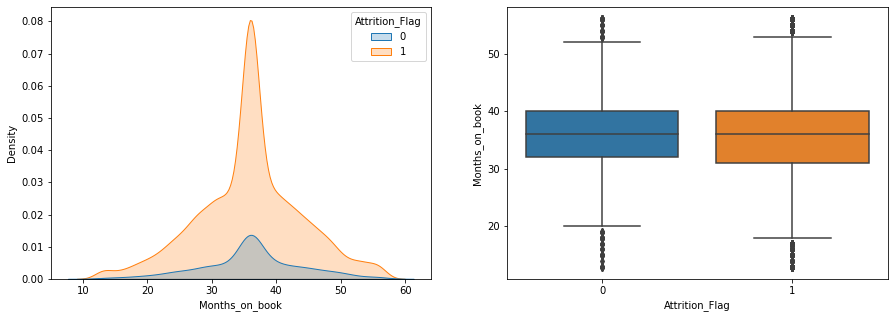

<IPython.core.display.Javascript object>

In [56]:
# Months on book and Attrited
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(x="Months_on_book", hue="Attrition_Flag", fill=True, data=bc, ax=ax[0])
sns.boxplot(x="Attrition_Flag", y="Months_on_book", data=bc, ax=ax[1])
fig.show()

* Months on book seems to have little impact on Attrition

#### Total Relationship Count

Attrition_Flag               0     1    All
Total_Relationship_Count                   
1                          233   677    910
2                          346   897   1243
3                          400  1905   2305
4                          225  1687   1912
5                          227  1664   1891
6                          196  1670   1866
All                       1627  8500  10127
------------------------------------------------------------------------------------------------------------------------


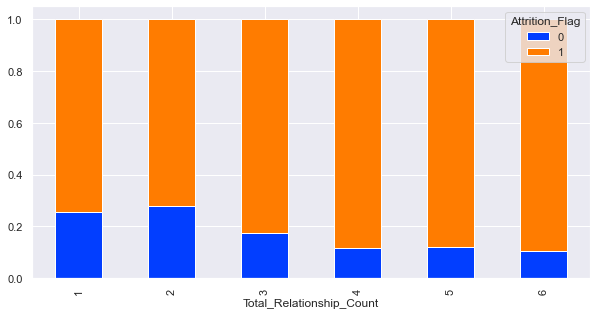

<IPython.core.display.Javascript object>

In [57]:
# Total relationship count
af_stacked_plot(bc["Total_Relationship_Count"])

* In general the more products a customer has with the bank the less likely they are to Attitre, however there is a slight increase ~ 2% in attrition between 1 and 2 products

#### Card Category

Attrition_Flag     0     1    All
Card_Category                    
Blue            1519  7917   9436
Gold              21    95    116
Platinum           5    15     20
Silver            82   473    555
All             1627  8500  10127
------------------------------------------------------------------------------------------------------------------------


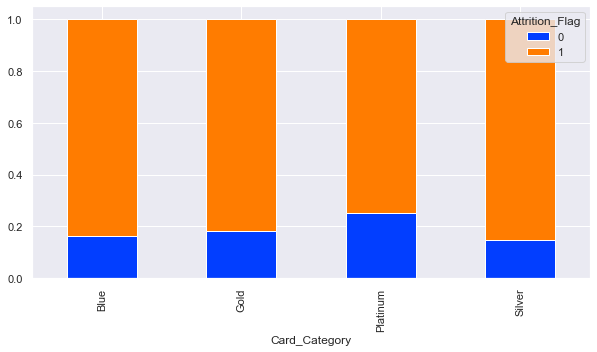

<IPython.core.display.Javascript object>

In [58]:
# Card Category
af_stacked_plot(bc["Card_Category"])

* Surprisingly customers with platinum cards have a higher percentage chance of attiring than others.  However there are only 20 total platinum cards.
* Silver has the lowest rate of attired customers with ~ 14% 

#### Income Category

Attrition_Flag      0     1    All
Income_Category                   
$120K +           126   601    727
$40K - $60K       271  1519   1790
$60K - $80K       189  1213   1402
$80K - $120K      242  1293   1535
Less than $40K    612  2949   3561
abc               187   925   1112
All              1627  8500  10127
------------------------------------------------------------------------------------------------------------------------


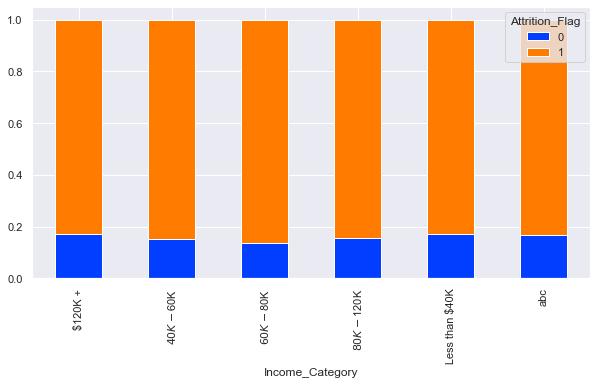

<IPython.core.display.Javascript object>

In [59]:
# Income Category
af_stacked_plot(bc["Income_Category"])

* Income seems to little impact on attrition with 60k - 80k being slightly better at 13%

#### Credit Limit

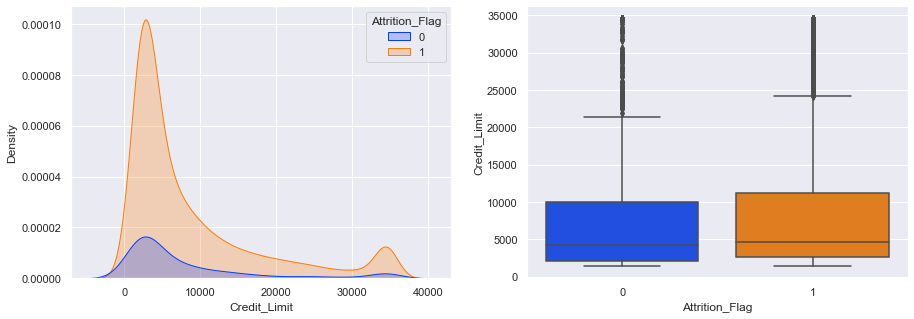

<IPython.core.display.Javascript object>

In [60]:
# Credit_Limit and Attrited
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(x="Credit_Limit", hue="Attrition_Flag", fill=True, data=bc, ax=ax[0])
sns.boxplot(x="Attrition_Flag", y="Credit_Limit", data=bc, ax=ax[1])
fig.show()

* Lower credit limits have a slightly higher attrition rate than higher 

#### Total Revolving Balance 

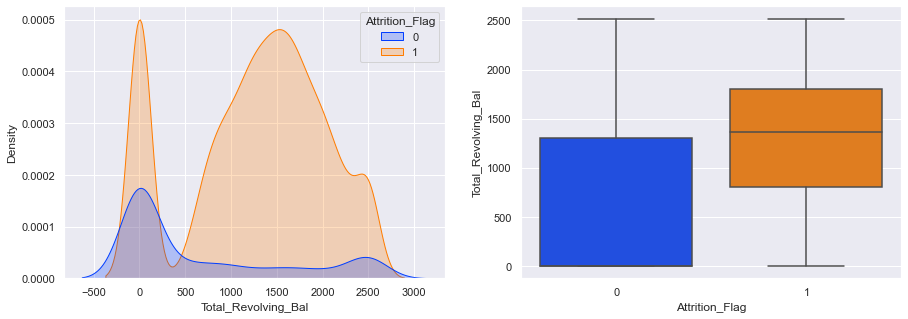

<IPython.core.display.Javascript object>

In [61]:
# Total_Revolving_Bal and Attrited
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(x="Total_Revolving_Bal", hue="Attrition_Flag", fill=True, data=bc, ax=ax[0])
sns.boxplot(x="Attrition_Flag", y="Total_Revolving_Bal", data=bc, ax=ax[1])
fig.show()

* Those with a revolving balance between 1000 and ~ 2200 have a lower attrition rate in general
* Most attritions are for total revolving balances lower than 500

#### Education Level

Attrition_Flag      0     1    All
Education_Level                   
College           154   859   1013
Doctorate          95   356    451
Graduate          487  2641   3128
High School       306  1707   2013
Post-Graduate      92   424    516
Uneducated        237  1250   1487
Unknown           256  1263   1519
All              1627  8500  10127
------------------------------------------------------------------------------------------------------------------------


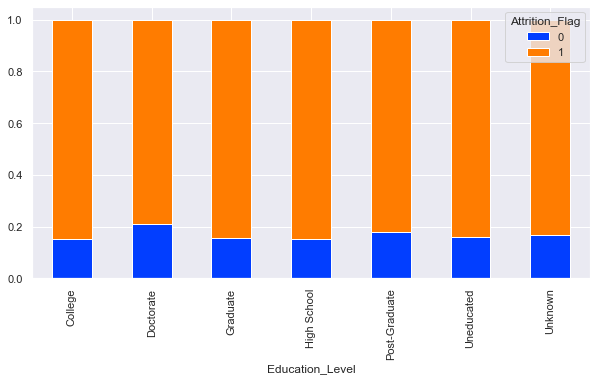

<IPython.core.display.Javascript object>

In [62]:
# Education_Level
af_stacked_plot(bc["Education_Level"])

* Education Level has relatively even attrition rates of ~ 15% with Doctorate having slightly higher at 21%

#### Gender

Attrition_Flag     0     1    All
Gender                           
F                930  4428   5358
M                697  4072   4769
All             1627  8500  10127
------------------------------------------------------------------------------------------------------------------------


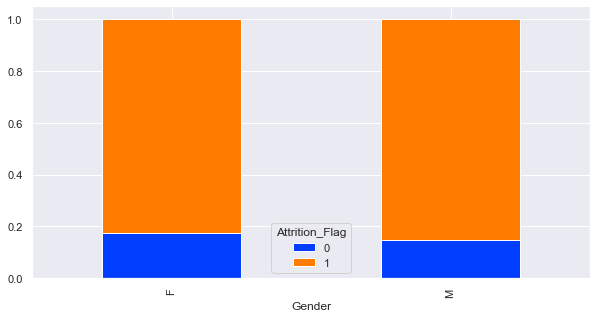

<IPython.core.display.Javascript object>

In [63]:
# Gender
af_stacked_plot(bc["Gender"])

* Gender has relatively even rates of attrition

#### Dependent_count

Attrition_Flag      0     1    All
Dependent_count                   
0                 135   769    904
1                 269  1569   1838
2                 417  2238   2655
3                 482  2250   2732
4                 260  1314   1574
5                  64   360    424
All              1627  8500  10127
------------------------------------------------------------------------------------------------------------------------


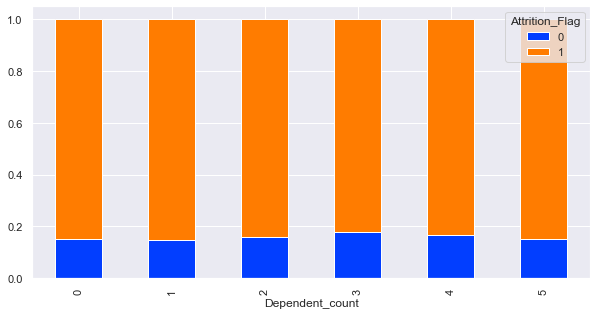

<IPython.core.display.Javascript object>

In [64]:
# Dependent_Count
af_stacked_plot(bc["Dependent_count"])

* Dependent_count shows relatively even distribution for attrition rate with 3 & 4 dependents having slightly higher rates of ~ 17%

#### Marital_Status

Attrition_Flag     0     1    All
Marital_Status                   
Divorced         121   627    748
Married          709  3978   4687
Single           668  3275   3943
Unknown          129   620    749
All             1627  8500  10127
------------------------------------------------------------------------------------------------------------------------


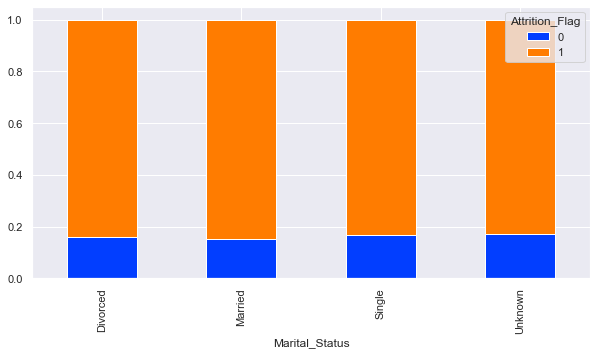

<IPython.core.display.Javascript object>

In [65]:
# Marital_Status
af_stacked_plot(bc["Marital_Status"])

* Marital_Status shows little impact on attrition rate with each category being about 15%

#### Contacts_Count_12_mon

Attrition_Flag            0     1    All
Contacts_Count_12_mon                   
0                         7   392    399
1                       108  1391   1499
2                       403  2824   3227
3                       681  2699   3380
4                       315  1077   1392
5                        59   117    176
6                        54     0     54
All                    1627  8500  10127
------------------------------------------------------------------------------------------------------------------------


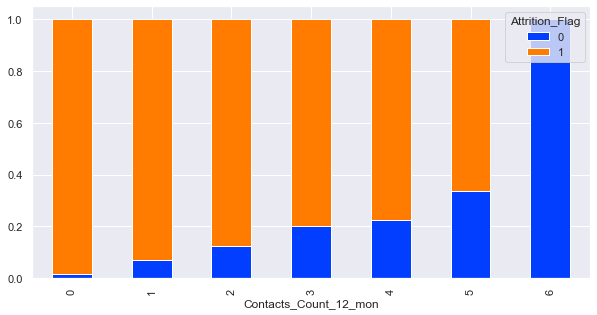

<IPython.core.display.Javascript object>

In [66]:
# Contacts_Count_12_mon
af_stacked_plot(bc["Contacts_Count_12_mon"])

* Surprisingly the more contact the customer had with the bank the more likely they were to attire.  Perhaps this reflects the bank increasingly reaching out to customers as time passed.
* All customers, 54, who had 6 contacts are flagged as attrited, with 5 contacts having ~ 33% attrition rate

#### Months Inactive

Attrition_Flag             0     1    All
Months_Inactive_12_mon                   
0                         15    14     29
1                        100  2133   2233
2                        505  2777   3282
3                        826  3020   3846
4                        130   305    435
5                         32   146    178
6                         19   105    124
All                     1627  8500  10127
------------------------------------------------------------------------------------------------------------------------


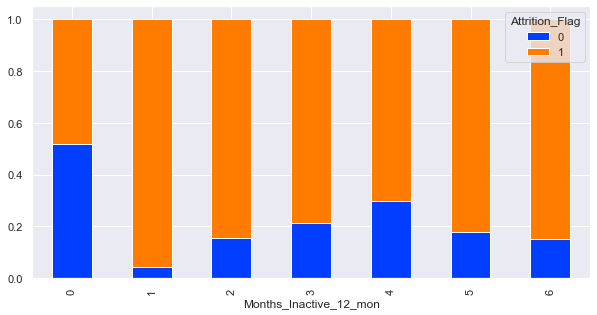

<IPython.core.display.Javascript object>

In [67]:
# Months_Inactive_12_mon
af_stacked_plot(bc["Months_Inactive_12_mon"])

* Those with 0 inactive months have an attrition rate of ~ 51%, however there are only 30 of these customers
* 4 months of inactivity has the next highest attrition rate at ~ 30% 

#### Avg_Open_To_Buy

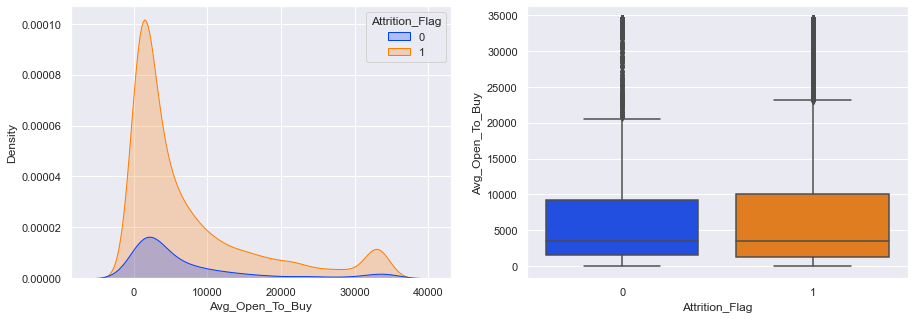

<IPython.core.display.Javascript object>

In [68]:
# Avg_Open_To_Buy and Attrited
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(x="Avg_Open_To_Buy", hue="Attrition_Flag", fill=True, data=bc, ax=ax[0])
sns.boxplot(x="Attrition_Flag", y="Avg_Open_To_Buy", data=bc, ax=ax[1])
fig.show()

* Avg_Open_To_Buy appears to have modest impact on attrition rate, with slightly less attrition for those with an average > 2000 credit remaining. 

#### Total_Trans_Amt

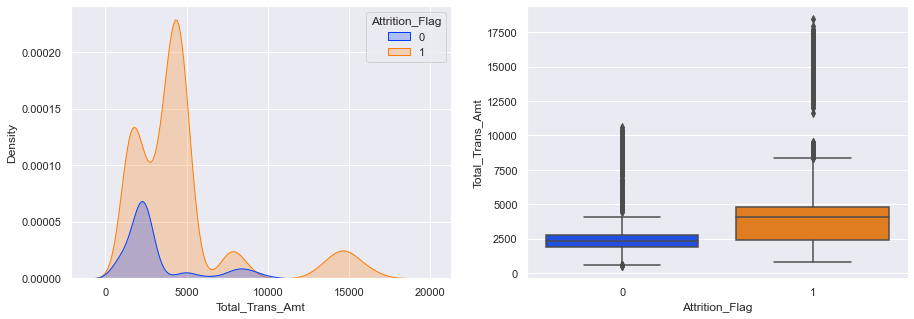

<IPython.core.display.Javascript object>

In [69]:
# Total_Trans_Amt and Attrited
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(x="Total_Trans_Amt", hue="Attrition_Flag", fill=True, data=bc, ax=ax[0])
sns.boxplot(x="Attrition_Flag", y="Total_Trans_Amt", data=bc, ax=ax[1])
fig.show()

* Customers with higher average transactions are less likely to attire, with customers > 10000 far less likely.
* Customers with average transactions between 0 - 4000 are more likely to attire

#### Total_Trans_Ct

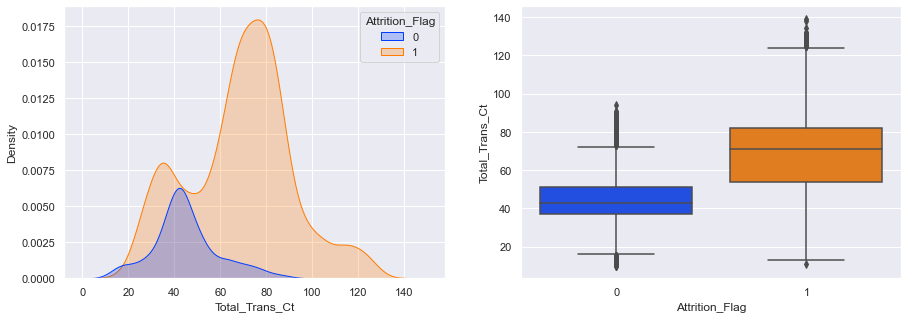

<IPython.core.display.Javascript object>

In [70]:
# Total_Trans_Ct and Attrited
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(x="Total_Trans_Ct", hue="Attrition_Flag", fill=True, data=bc, ax=ax[0])
sns.boxplot(x="Attrition_Flag", y="Total_Trans_Ct", data=bc, ax=ax[1])
fig.show()

* There are no attrited customers with more than 100 transactions in the last 12 months
* The highest rate of attrition is for customers with about 38 to 54 transactions in the last 12 months

#### Total_Ct_Chng_Q4_Q1

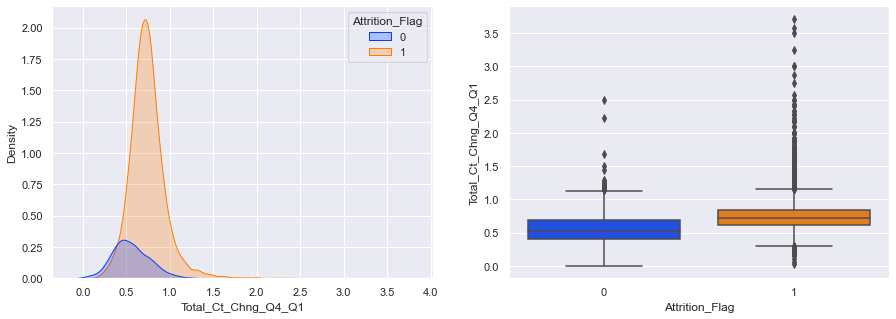

<IPython.core.display.Javascript object>

In [71]:
# Total_Ct_Chng_Q4_Q1 and Attrited
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(x="Total_Ct_Chng_Q4_Q1", hue="Attrition_Flag", fill=True, data=bc, ax=ax[0])
sns.boxplot(x="Attrition_Flag", y="Total_Ct_Chng_Q4_Q1", data=bc, ax=ax[1])
fig.show()

* Customers with a lower transaction count ratio, 0.4 to 0.7 are more likely to attire.

#### Total_Amt_Chng_Q4_Q1

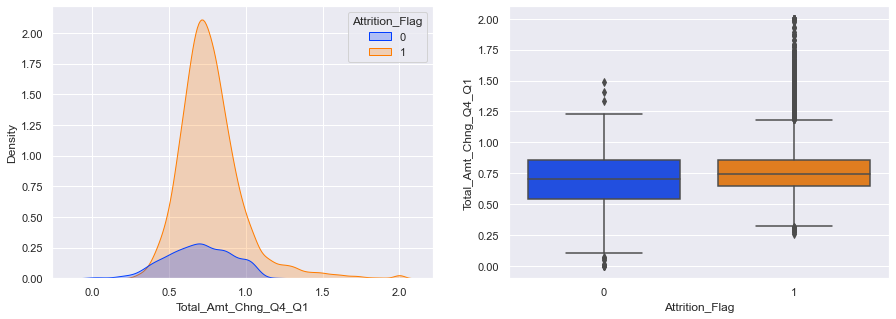

<IPython.core.display.Javascript object>

In [72]:
# Total_Amt_Chng_Q4_Q1 and Attrited
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(
    x="Total_Amt_Chng_Q4_Q1", hue="Attrition_Flag", fill=True, data=bc, ax=ax[0]
)
sns.boxplot(x="Attrition_Flag", y="Total_Amt_Chng_Q4_Q1", data=bc, ax=ax[1])
fig.show()

* Customers with a lower transaction amount ratio, 0.55 to 0.80 are more likely to attire
* Very few customers with a transaction amount ratio > 0.8 attrited.

#### Avg_Utilization_Ratio

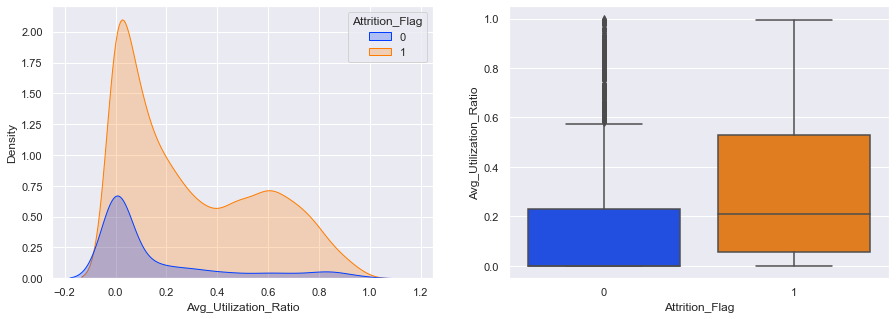

<IPython.core.display.Javascript object>

In [73]:
# Avg_Utilization_Ratio and Attrited
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(
    x="Avg_Utilization_Ratio", hue="Attrition_Flag", fill=True, data=bc, ax=ax[0]
)
sns.boxplot(x="Attrition_Flag", y="Avg_Utilization_Ratio", data=bc, ax=ax[1])
fig.show()

* Customers with a average utilization ratio > 0.25 are far less likely to attire


<AxesSubplot:xlabel='Total_Trans_Amt', ylabel='Avg_Utilization_Ratio'>

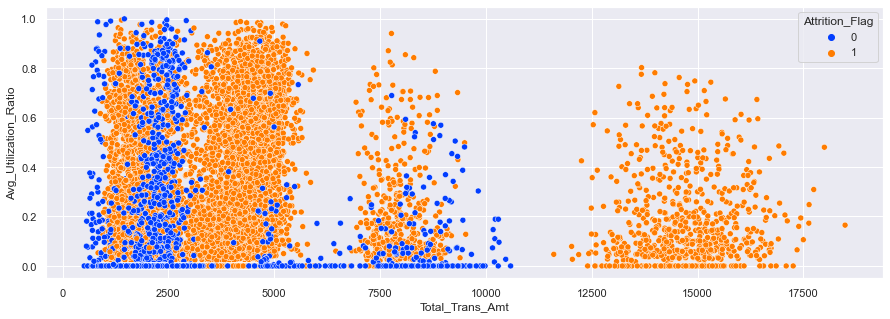

<IPython.core.display.Javascript object>

In [74]:
# Avg Utilization Ratio, Total Trans Amt & Attrition Flag
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x="Total_Trans_Amt",
    y="Avg_Utilization_Ratio",
    hue="Attrition_Flag",
    palette="bright",
    data=bc,
)

* No attrition for customers with total trans amounts > ~11,000 and few between 2700 and 5200
* It is interesting that there are a number of customers with utilization ratios of 0 or near 0 who have high total transaction amounts.  Perhaps total transactions include other types of products.

<AxesSubplot:xlabel='Credit_Limit', ylabel='Total_Trans_Amt'>

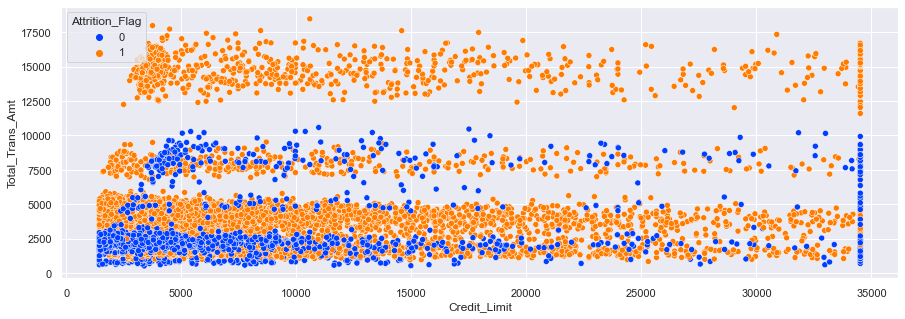

<IPython.core.display.Javascript object>

In [75]:
# Total Trans Amt, Credit Limit & Attrition Flag
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x="Credit_Limit",
    y="Total_Trans_Amt",
    hue="Attrition_Flag",
    palette="bright",
    data=bc,
)

* A surprising number of customers with the max credit limit attired
* The majority of attired customers had a total transaction amount < 3000 and a credit limit < 10000

<AxesSubplot:xlabel='Total_Revolving_Bal', ylabel='Total_Trans_Amt'>

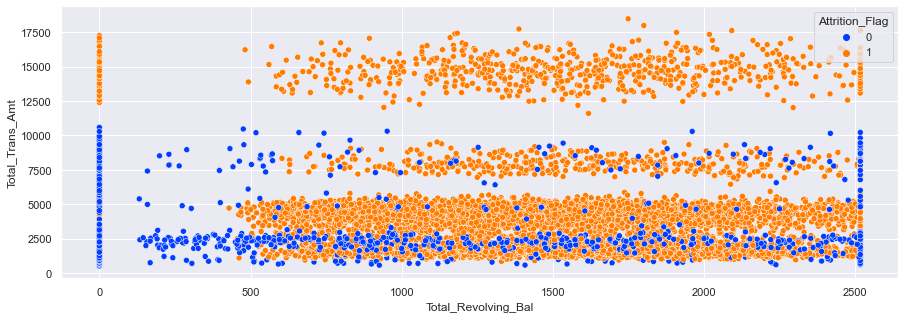

<IPython.core.display.Javascript object>

In [76]:
# Total Trans Amt, Total Revolving Bal & Attrition Flag
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x="Total_Revolving_Bal",
    y="Total_Trans_Amt",
    hue="Attrition_Flag",
    palette="bright",
    data=bc,
)

* Nearly all customers with a revolving balance < 500 attired, most of those have a Total transaction amount of < 3000
* Nearly all customers with a 0 revolving balance attired

<AxesSubplot:xlabel='Months_on_book', ylabel='Customer_Age'>

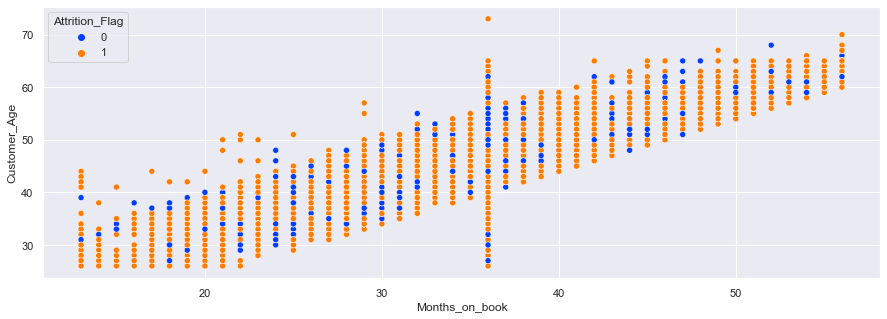

<IPython.core.display.Javascript object>

In [77]:
# Months on Book, Age & Attrition Flag
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x="Months_on_book",
    y="Customer_Age",
    hue="Attrition_Flag",
    palette="bright",
    data=bc,
)

* We know that months on book and age are highly correlated, but we still see the odd spike at 3 years.
* Months on book and customer age appear to have little impact on attrition

### EDA Key Observations
* Attrition_Flag is our target variable with 16.1% of customers in the data being attrited, or account closed. The target variable is imbalanced.
* For months on book, there is very high spike, nearly 25% of customers, at 36 months (3 years).
* Income Category has a category of abc, it is not clear what this category represents and no patterns could be found.
* The majority of customers have 3 or more products with the bank with 4,5 & 6 accounting for ~ 56%
* Over the last 12 months most customers have had at least 1 month of inactivity with the majority having 3 months. Only 0.02% have not had inactivity in the last 12 months. It is unclear if this is inactivity for a consecutive amount of time or cumulative over 1 year.
* Credit_Limit has many outliers above ~ 25,000 with a spike at 34,516 (5%). The number 34516 seems odd as a cap.
* Nearly 25% of customers do not carry a revolving balance with the majority having between 1000 and 2000.
* The majority of customers have < 5000 open credit throughout the year, and several with > ~ 33,000.
* The vast majority of customers have a "Blue" Card at 93%.  Platinum card accounts for only 0.2%
* Surprisingly customers with platinum cards have a higher percentage chance of attiring than others. However there are only 20 total platinum cards. Silver has the lowest rate of attired customers with ~ 14%
* Those with a revolving balance between 1000 and ~ 2200 have a lower attrition rate in general
* Most attritions are for total revolving balances lower than 500
* Surprisingly the more contact the customer had with the bank the more likely they were to attire. Perhaps this reflects the bank increasingly reaching out to customers as time passed.
* All customers, 54, who had 6 contacts are flagged as attrited, with 5 contacts having ~ 33% attrition rate
* Those with 0 inactive months have an attrition rate of ~ 51%, however there are only 30 of these customers
* 4 months of inactivity has the next highest attrition rate at ~ 30%
* Customers with higher average transactions are less likely to attire, with customers > 10000 far less likely.
* Customers with average transactions between 0 - 4000 are more likely to attire
* There are no attrited customers with more than 100 transactions in the last 12 months
* The highest rate of attrition is for customers with about 38 to 54 transactions in the last 12 months
* Very few customers with a transaction amount ratio > 0.8 attrited.
* Customers with a average utilization ratio > 0.25 are far less likely to attire
* No attrition for customers with total trans amounts > ~11,000 and few between 2700 and 5200
* It is interesting that there are a number of customers with utilization ratios of 0 or near 0 who have high total transaction amounts. Perhaps total transactions include other types of products.
* A surprising number of customers with the max credit limit attired
* The majority of attired customers had a total transaction amount < 3000 and a credit limit < 10000
 

### Data Preparation for Modeling
 - We will use a copy of the data set bc1 to determine pre-processing  and best model
 - We will use a copy of the data sec bc_final for building a pipeline for final production

In [78]:
# Create copy of data prior to prep for modeling
bc1 = bc.copy()

<IPython.core.display.Javascript object>

In [79]:
# Dropping columns with high correlation
bc1.drop(
    columns=[
        "Avg_Open_To_Buy",
        "Total_Trans_Amt",
        "Months_on_book",
    ],
    inplace=True,
)

bc1.head(3)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,45,M,3,High School,Married,$60K - $80K,Blue,5,1,3,12691.000,777,1.335,42,1.625,0.061
1,1,49,F,5,Graduate,Single,Less than $40K,Blue,6,1,2,8256.000,864,1.541,33,3.714,0.105
2,1,51,M,3,Graduate,Married,$80K - $120K,Blue,4,1,0,3418.000,0,2.000,20,2.333,0.000


<IPython.core.display.Javascript object>

In [80]:
# looking at value counts for non-numeric features

num_to_display = 35
for colname in bc.dtypes[bc.dtypes == "category"].index:
    val_counts = bc[colname].value_counts(dropna=False)
    print(val_counts[:num_to_display])
    if len(val_counts) > num_to_display:
        print(f"Only displaying first {num_to_display} of {len(val_counts)} values.")
    print("\n")  # just for more space between

F    5358
M    4769
Name: Gender, dtype: int64


Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64


Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64


Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: Income_Category, dtype: int64


Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64




<IPython.core.display.Javascript object>

### Rank order encode Income_Category, Card_Category, Education_Level

In [81]:
# Rank order Income_Category
icr_values = {
    "Less than $40K": 1,
    "$40K - $60K": 2,
    "$60K - $80K": 3,
    "$80K - $120K": 4,
    "$120K +": 5,
    "abc": 0,
}
bc1 = bc1.replace({"Income_Category": icr_values})

# Rank order Card_Category
ccr_values = {"Blue": 1, "Silver": 2, "Gold": 3, "Platinum": 4}
bc1 = bc1.replace({"Card_Category": ccr_values})

# Rank order Education_Level
elr_values = {
    "Unknown": 0,
    "Uneducated": 1,
    "High School": 2,
    "College": 3,
    "Graduate": 4,
    "Post-Graduate": 5,
    "Doctorate": 6,
}
bc1 = bc1.replace({"Education_Level": elr_values})

<IPython.core.display.Javascript object>

In [82]:
bc1.head(10)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,45,M,3,2,Married,3,1,5,1,3,12691.000,777,1.335,42,1.625,0.061
1,1,49,F,5,4,Single,1,1,6,1,2,8256.000,864,1.541,33,3.714,0.105
2,1,51,M,3,4,Married,4,1,4,1,0,3418.000,0,2.000,20,2.333,0.000
3,1,40,F,4,2,Unknown,1,1,3,4,1,3313.000,2517,1.405,20,2.333,0.760
4,1,40,M,3,1,Married,3,1,5,1,0,4716.000,0,2.000,28,2.500,0.000
5,1,44,M,2,4,Married,2,1,3,1,2,4010.000,1247,1.376,24,0.846,0.311
6,1,51,M,4,0,Married,5,3,6,1,3,34516.000,2264,1.975,31,0.722,0.066
7,1,32,M,0,2,Unknown,3,2,2,2,2,29081.000,1396,2.000,36,0.714,0.048
8,1,37,M,3,1,Single,3,1,5,2,0,22352.000,2517,2.000,24,1.182,0.113
9,1,48,M,2,4,Single,4,1,6,3,3,11656.000,1677,1.524,32,0.882,0.144


<IPython.core.display.Javascript object>

#### Create a copy of the dataset for later pipeline

In [83]:
bc_final = bc1.copy()

<IPython.core.display.Javascript object>

### Split Data

In [84]:
X = bc1.drop(["Attrition_Flag"], axis=1)
y = bc1["Attrition_Flag"]

<IPython.core.display.Javascript object>

In [85]:
# Splitting data into training, validation and test sets:

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2021, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=2021, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(6075, 16) (2026, 16) (2026, 16)


<IPython.core.display.Javascript object>

In [86]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6075 entries, 7131 to 3456
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Customer_Age              6075 non-null   int64   
 1   Gender                    6075 non-null   category
 2   Dependent_count           6075 non-null   int64   
 3   Education_Level           6075 non-null   int64   
 4   Marital_Status            6075 non-null   category
 5   Income_Category           6075 non-null   int64   
 6   Card_Category             6075 non-null   int64   
 7   Total_Relationship_Count  6075 non-null   int64   
 8   Months_Inactive_12_mon    6075 non-null   int64   
 9   Contacts_Count_12_mon     6075 non-null   int64   
 10  Credit_Limit              6075 non-null   float64 
 11  Total_Revolving_Bal       6075 non-null   int64   
 12  Total_Amt_Chng_Q4_Q1      6075 non-null   float64 
 13  Total_Trans_Ct            6075 non-null   int

<IPython.core.display.Javascript object>

### One Hot Encode split data

In [87]:
# Creating dummy variables for categorical variables
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_val = pd.get_dummies(data=X_val, drop_first=True)
X_test = pd.get_dummies(data=X_test, drop_first=True)

<IPython.core.display.Javascript object>

### Scale numeric variables with larger values with MinMaxScaler

In [88]:
X_train.head(3)

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
7131,41,4,0,2,1,5,1,2,2128.000,1383,0.679,81,0.761,0.650,0,0,1,0
6005,46,4,0,2,1,4,2,3,2505.000,0,0.800,80,0.860,0.000,0,0,0,1
5079,44,3,3,2,1,3,1,2,3256.000,1013,0.988,81,0.841,0.311,0,1,0,0


<IPython.core.display.Javascript object>

In [89]:
from sklearn.preprocessing import minmax_scale

X_train[
    ["Customer_Age", "Credit_Limit", "Total_Revolving_Bal", "Total_Trans_Ct"]
] = minmax_scale(
    X_train[["Customer_Age", "Credit_Limit", "Total_Revolving_Bal", "Total_Trans_Ct"]]
)

X_val[
    ["Customer_Age", "Credit_Limit", "Total_Revolving_Bal", "Total_Trans_Ct"]
] = minmax_scale(
    X_val[["Customer_Age", "Credit_Limit", "Total_Revolving_Bal", "Total_Trans_Ct"]]
)

X_test[
    ["Customer_Age", "Credit_Limit", "Total_Revolving_Bal", "Total_Trans_Ct"]
] = minmax_scale(
    X_test[["Customer_Age", "Credit_Limit", "Total_Revolving_Bal", "Total_Trans_Ct"]]
)

<IPython.core.display.Javascript object>

In [90]:
display(X_train.head(3))
display(X_val.head(3))
display(X_test.head(3))

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
7131,0.357,4,0,2,1,5,1,2,0.021,0.549,0.679,0.582,0.761,0.650,0,0,1,0
6005,0.476,4,0,2,1,4,2,3,0.032,0.000,0.800,0.574,0.860,0.000,0,0,0,1
5079,0.429,3,3,2,1,3,1,2,0.055,0.402,0.988,0.582,0.841,0.311,0,1,0,0


,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
4922,0.298,4,2,4,1,6,1,0,0.021,0.525,0.596,0.481,1.000,0.621,1,0,0,1
9826,0.362,3,3,1,1,4,2,2,0.129,0.860,0.790,0.853,0.935,0.380,0,0,1,0
3447,0.638,2,1,2,1,3,1,3,0.148,0.564,0.529,0.457,0.438,0.224,1,0,0,0


,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
5107,0.500,3,4,2,1,6,3,4,0.407,0.000,0.381,0.118,0.368,0.000,0,1,0,0
2519,0.273,1,4,4,1,6,2,5,0.754,0.542,1.394,0.354,1.000,0.052,1,0,1,0
8231,0.545,1,0,1,1,1,1,2,0.023,0.611,0.843,0.504,0.974,0.696,0,0,0,1


<IPython.core.display.Javascript object>

## Build Models

### Model evaluation - Using Recall
We will be using Recall as the primary metric for evaluating models, we want to reduce False Negatives as much as possible  so ware are not identifying customers who are not likely to churn, we want to ensure service improvements are correctly targeted.

In [91]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [92]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

### Cross Validation on models
We will create and cross validate 7 models.  We will then choose the top 3 performing models and work to improve them.
* Models
    * Logistic Regression
    * Decision Tree
    * Bagging
    * Random Forest
    * Adaboost
    * Gradient Boosting
    * XGBoosting

In [93]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic Regression", LogisticRegression(random_state=2021)))
models.append(("dtree", DecisionTreeClassifier(random_state=2021)))
models.append(("Bagging", BaggingClassifier(random_state=2021)))
models.append(("Random forest", RandomForestClassifier(random_state=2021)))
models.append(("GBM", GradientBoostingClassifier(random_state=2021)))
models.append(("Adaboost", AdaBoostClassifier(random_state=2021)))
models.append(("Xgboost", XGBClassifier(random_state=2021, eval_metric="logloss")))


results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
score = []
scoret = []
# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores * 100))




Cross-Validation Performance:

Logistic Regression: 97.15617002443764
dtree: 92.93982951374858
Bagging: 95.84234832303873
Random forest: 97.96030325771132
GBM: 97.66605091496852
Adaboost: 96.7444053185553
Xgboost: 97.39157959552809

Validation Performance:

Logistic Regression: 96.82352941176471
dtree: 93.88235294117648
Bagging: 95.23529411764706
Random forest: 97.70588235294117
GBM: 97.29411764705883
Adaboost: 95.17647058823529
Xgboost: 96.88235294117648


<IPython.core.display.Javascript object>

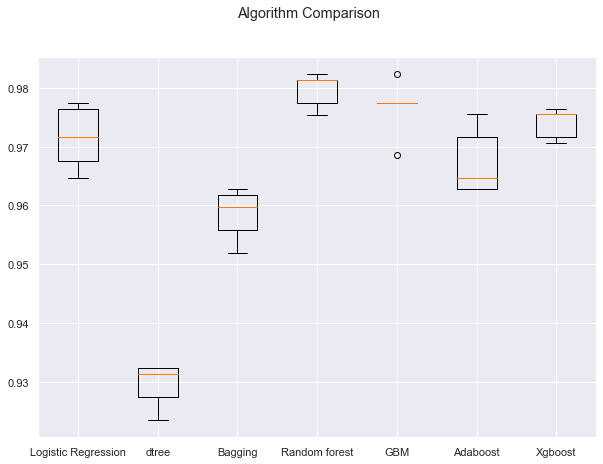

<IPython.core.display.Javascript object>

In [94]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

#### All models are performing very well on Test & Validation data and appear to be generalizing well
* We will try and improve on the top 3 Models with Hyperparameter Tuning

    * Gradient Boosting (GBM) - 97.82  |  98.41
    * Random Forest - 97.72  |  98.23
    * XGBoost - 97.33  |  97.88
    
Gradient Boost has the best performance but is showing outliers and so may not perform as consistently in production as XGBoost and Random Forest

## Hyperparameter Tuning
We will tune the top 3 models using RandomizedSearchCV

### Gradient Boost 

Initial Cross-Validtion Scores - Test - 97.82, Validation - 98.41

In [95]:
%%time 

model = GradientBoostingClassifier(random_state=2021)


# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
    "subsample": [int(x) for x in np.linspace(start=0.1, stop=1, num=5)],
    "max_features": [int(x) for x in np.linspace(start=0.1, stop=1, num=5)],
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    n_jobs=-1,
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring=scorer,
    cv=5,
    random_state=2021,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'subsample': 1, 'n_estimators': 311, 'max_features': 1} with CV score=0.9803885008370374:
Wall time: 8.56 s


<IPython.core.display.Javascript object>

In [96]:
# Creating new pipeline with best parameters
GBM_Tuned = GradientBoostingClassifier(
    random_state=2021, subsample=1, n_estimators=311, max_features=1
)

# Fit the model on training data
GBM_Tuned.fit(X_train, y_train)

GradientBoostingClassifier(max_features=1, n_estimators=311, random_state=2021,
                           subsample=1)

<IPython.core.display.Javascript object>

In [97]:
# Calculating different metrics on train set
GBM_Tuned_train = model_performance_classification_sklearn(GBM_Tuned, X_train, y_train)
print("Training Performance:")
GBM_Tuned_train

Training Performance:


,Accuracy,Recall,Precision,F1
0,0.950,0.987,0.955,0.971


<IPython.core.display.Javascript object>

In [98]:
# Calculating different metrics on validation set
GBM_Tuned_val = model_performance_classification_sklearn(GBM_Tuned, X_val, y_val)
print("Validation Performance:")
GBM_Tuned_val

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.929,0.969,0.948,0.958


<IPython.core.display.Javascript object>

In [99]:
# Calculating different metrics on validation set
GBM_Tuned_test = model_performance_classification_sklearn(GBM_Tuned, X_test, y_test)
print("Test Performance:")
GBM_Tuned_test

Test Performance:


,Accuracy,Recall,Precision,F1
0,0.939,0.981,0.948,0.964


<IPython.core.display.Javascript object>

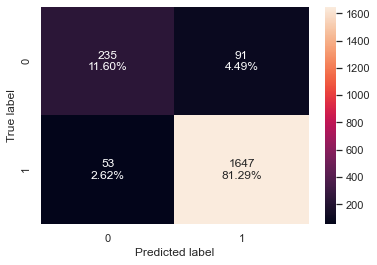

<IPython.core.display.Javascript object>

In [100]:
# creating confusion matrix
confusion_matrix_sklearn(GBM_Tuned, X_val, y_val)

#### Gradient Boost Tuned
Tuning the Gradient Boost model has improved overall recall scores.  Train ~ 0.8% and Validation - ~0.1%

### XGBoost 

Initial Cross-Validtion Scores - Test - 97.33, Validation - 97.88

In [101]:
%%time

# defining model
model = XGBClassifier(random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomizedSearchCV
param_grid={'n_estimators':np.arange(10,200,10),
            'scale_pos_weight':[2,5,7,10,15],
            'learning_rate':[0.01,0.1,0.2,0.05],
            'gamma':[0,1,3,5],
            'subsample':[0.8,0.9,1],
            'max_depth':np.arange(1,5,1),
            'reg_lambda':[5,10]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
xgb_tuned = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, 
                               scoring=scorer, cv=10, random_state=1, n_jobs = -1, verbose=2)

#Fitting parameters in RandomizedSearchCV
xgb_tuned.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(xgb_tuned.best_params_,xgb_tuned.best_score_))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters are {'subsample': 1, 'scale_pos_weight': 15, 'reg_lambda': 10, 'n_estimators': 30, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 3} with CV score=1.0:
Wall time: 1min 36s


<IPython.core.display.Javascript object>

In [102]:
# building model with best parameters
xgb_tuned = XGBClassifier(
    random_state=2021,
    n_estimators=30,
    scale_pos_weight=15,
    gamma=3,
    subsample=1,
    learning_rate=0.1,
    eval_metric="logloss",
    max_depth=1,
    reg_lambda=10,
)
# Fit the model on training data
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=3, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=8,
              num_parallel_tree=1, random_state=2021, reg_alpha=0,
              reg_lambda=10, scale_pos_weight=15, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [103]:
# Calculating different metrics on train set
xgb_tuned_train = model_performance_classification_sklearn(xgb_tuned, X_train, y_train)
print("Training performance:")
xgb_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.839,1.000,0.839,0.913


<IPython.core.display.Javascript object>

In [104]:
# Calculating different metrics on validation set
xgb_tuned_val = model_performance_classification_sklearn(xgb_tuned, X_val, y_val)
print("Validation performance:")
xgb_tuned_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.839,1.000,0.839,0.913


<IPython.core.display.Javascript object>

In [105]:
# Calculating different metrics on validation set
xgb_tuned_test = model_performance_classification_sklearn(xgb_tuned, X_test, y_test)
print("Test Performance:")
xgb_tuned_test

Test Performance:


,Accuracy,Recall,Precision,F1
0,0.840,1.000,0.840,0.913


<IPython.core.display.Javascript object>

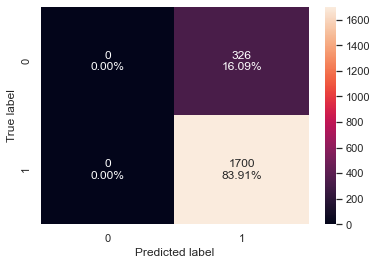

<IPython.core.display.Javascript object>

In [106]:
# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned, X_val, y_val)

#### Gradient Boost Tuned
* Tuning the Gradient Boost model has improved overall recall scores.  Train ~ 2.67% and Validation - ~ 2.11%
* This model has a 1.00 recall test and validation score.  It is possible that the model is fitting to noise, we will need to check it's test score.

### Random Forest 

Initial Cross-Validtion Scores - Test - 97.72, Validation - 98.23

In [107]:
%%time

# defining model
model = RandomForestClassifier(random_state=2021)

# Parameter grid to pass in RandomizedSearchCV
param_grid={
    "n_estimators":np.arange(10,200,10),
    "min_samples_leaf": np.arange(1,10,2),
    "max_features": [0.1, 0.3, 0.7, 0.9],
    "max_samples": [0.1, 0.5, 0.7, 0.9],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
rf_tuned = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, 
                               scoring=scorer, cv=10, random_state=1, n_jobs = -1, verbose=2)

#Fitting parameters in RandomizedSearchCV
rf_tuned.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(rf_tuned.best_params_,rf_tuned.best_score_))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters are {'n_estimators': 160, 'min_samples_leaf': 9, 'max_samples': 0.1, 'max_features': 0.1} with CV score=0.9998039215686274:
Wall time: 3min 34s


<IPython.core.display.Javascript object>

In [108]:
# building model with best parameters
rf_tuned = RandomForestClassifier(
    random_state=2021,
    n_estimators=190,
    min_samples_leaf=7,
    max_features=0.1,
    max_samples=0.1,
)
# Fit the model on training data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features=0.1, max_samples=0.1, min_samples_leaf=7,
                       n_estimators=190, random_state=2021)

<IPython.core.display.Javascript object>

In [109]:
# Calculating different metrics on train set
rf_tuned_train = model_performance_classification_sklearn(rf_tuned, X_train, y_train)
print("Training performance:")
rf_tuned_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.862,1.000,0.859,0.924


<IPython.core.display.Javascript object>

In [110]:
# Calculating different metrics on validation set
rf_tuned_val = model_performance_classification_sklearn(rf_tuned, X_val, y_val)
print("Validation performance:")
rf_tuned_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.854,0.999,0.853,0.920


<IPython.core.display.Javascript object>

In [111]:
# Calculating different metrics on validation set
rf_tuned_test = model_performance_classification_sklearn(rf_tuned, X_test, y_test)
print("Test Performance:")
rf_tuned_test

Test Performance:


,Accuracy,Recall,Precision,F1
0,0.860,0.999,0.858,0.923


<IPython.core.display.Javascript object>

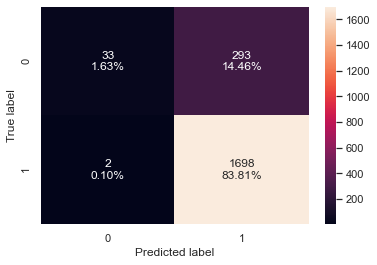

<IPython.core.display.Javascript object>

In [112]:
# creating confusion matrix
confusion_matrix_sklearn(rf_tuned, X_val, y_val)

#### Random Forest Tuned
* Tuning the Random Forest model has improved overall recall scores.  Train ~ 2.18% and Validation - ~ 1.67%
 * This model has a 99.9 recall test and validation score.  It is possible that the model is fitting to noise, we will need to check it's test score.

### Oversampling Data - SMOTE
All models are performing very well and are generalizing well, however we want to see how oversampling the train data will impact results. 

In [113]:
print("Before UpSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UpSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
X_val_res, y_val_res = sm.fit_resample(X_val, y_val.ravel())


print("After UpSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After UpSampling, counts of label '0': {} \n".format(sum(y_train_res == 0)))


print("After UpSampling, the shape of train_X: {}".format(X_train_res.shape))
print("After UpSampling, the shape of train_y: {} \n".format(y_train_res.shape))

Before UpSampling, counts of label '1': 5099
Before UpSampling, counts of label '0': 976 

After UpSampling, counts of label '1': 5099
After UpSampling, counts of label '0': 5099 

After UpSampling, the shape of train_X: (10198, 18)
After UpSampling, the shape of train_y: (10198,) 



<IPython.core.display.Javascript object>

In [114]:
# Calculating metrics on oversampled train set for Gradient Boosted model
GBM_Tuned_OverTrained = model_performance_classification_sklearn(
    GBM_Tuned, X_train_res, y_train_res
)
print("Oversampled Training performance:")
GBM_Tuned_OverTrained

Oversampled Training performance:


,Accuracy,Recall,Precision,F1
0,0.842,0.987,0.765,0.862


<IPython.core.display.Javascript object>

In [115]:
# Calculating metrics on oversampled val set for Gradient Boosted model
GBM_Tuned_OverTrained_val = model_performance_classification_sklearn(
    GBM_Tuned, X_val_res, y_val_res
)
print("Oversampled Validation performance:")
GBM_Tuned_OverTrained_val

Oversampled Validation performance:


,Accuracy,Recall,Precision,F1
0,0.836,0.969,0.766,0.856


<IPython.core.display.Javascript object>

In [116]:
# Calculating metrics on oversampled train set for XGBoosted model
xgb_tuned_OverTrained = model_performance_classification_sklearn(
    xgb_tuned, X_train_res, y_train_res
)
print("Oversampled Training performance:")
xgb_tuned_OverTrained

Oversampled Training performance:


,Accuracy,Recall,Precision,F1
0,0.500,1.000,0.500,0.667


<IPython.core.display.Javascript object>

In [117]:
# Calculating metrics on oversampled val set for Gradient Boosted model
xgb_tuned_OverTrained_val = model_performance_classification_sklearn(
    xgb_tuned, X_val_res, y_val_res
)
print("Oversampled Validation performance:")
xgb_tuned_OverTrained_val

Oversampled Validation performance:


,Accuracy,Recall,Precision,F1
0,0.500,1.000,0.500,0.667


<IPython.core.display.Javascript object>

In [118]:
# Calculating metrics on oversampled train set for Random Forest model
rf_tuned_OverTrained = model_performance_classification_sklearn(
    rf_tuned, X_train_res, y_train_res
)
print("Oversampled Training performance:")
rf_tuned_OverTrained

Oversampled Training performance:


,Accuracy,Recall,Precision,F1
0,0.565,1.000,0.535,0.697


<IPython.core.display.Javascript object>

#### Oversampling data set with SMOTE showed no impact on recall scores for the train set

### Undersampling Data - IMBLearn RandomUndersampling
All models are performing very well and are generalizing well, however we want to see how undersampling the train data will impact results. 

In [119]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_rus_val, y_rus_val = rus.fit_resample(X_val, y_val)

print("After Undersampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After Undersampling, counts of label '0': {} \n".format(sum(y_rus == 0)))


print("After Undersampling, the shape of train_X: {}".format(X_rus.shape))
print("After Undersampling, the shape of train_y: {} \n".format(y_rus.shape))

Before Undersampling, counts of label '1': 5099
Before Undersampling, counts of label '0': 976 

After Undersampling, counts of label '1': 976
After Undersampling, counts of label '0': 976 

After Undersampling, the shape of train_X: (1952, 18)
After Undersampling, the shape of train_y: (1952,) 



<IPython.core.display.Javascript object>

In [120]:
# Calculating metrics on undersampled train set for Gradient Boosted model
GBM_Tuned_UnderTrained = model_performance_classification_sklearn(
    GBM_Tuned, X_rus, y_rus
)
print("Undersampled Training performance:")
GBM_Tuned_UnderTrained

Undersampled Training performance:


,Accuracy,Recall,Precision,F1
0,0.871,0.984,0.803,0.884


<IPython.core.display.Javascript object>

In [121]:
# Calculating metrics on undersampled train set for Gradient Boosted model
GBM_Tuned_UnderTrained_val = model_performance_classification_sklearn(
    GBM_Tuned, X_rus_val, y_rus_val
)
print("Undersampled Training performance:")
GBM_Tuned_UnderTrained

Undersampled Training performance:


,Accuracy,Recall,Precision,F1
0,0.871,0.984,0.803,0.884


<IPython.core.display.Javascript object>

In [122]:
# Calculating metrics on undersampled train set for XGBoosted model
xgb_tuned_UnderTrained = model_performance_classification_sklearn(
    xgb_tuned, X_rus, y_rus
)
print("Undersampled Training performance:")
xgb_tuned_UnderTrained

Undersampled Training performance:


,Accuracy,Recall,Precision,F1
0,0.500,1.000,0.500,0.667


<IPython.core.display.Javascript object>

In [123]:
# Calculating metrics on undersampling train set for Randome Forest model
rf_tuned_UnderTrained = model_performance_classification_sklearn(rf_tuned, X_rus, y_rus)
print("Undersampled Training performance:")
rf_tuned_UnderTrained

Undersampled Training performance:


,Accuracy,Recall,Precision,F1
0,0.570,1.000,0.537,0.699


<IPython.core.display.Javascript object>

### Model Comparison

In [124]:
# Function to build model_comparison Data Frame
def model_comparison():

    comparison_frame = pd.DataFrame(
        {
            "Model": [
                "CV Gradient Boosted",
                "CV XGBoost",
                "CV Random Forest",
                "GBM Tuned",
                "XGB Tuned",
                "RF Tuned",
                "GBM Oversample",
                "XGB Oversample",
                "RF Oversample",
                "GBM Undersample",
                "XGB Undersample",
                "RF Undersample",
            ],
            "Train Recall": [
                97.8,
                97.3,
                97.7,
                98.6,
                100,
                99.9,
                98.6,
                100,
                99.9,
                99.2,
                100,
                100,
            ],
            "Validation Recall": [
                98.41,
                97.88,
                98.23,
                98.4,
                100,
                99.9,
                98.4,
                100,
                99.9,
                99.2,
                100,
                100,
            ],
        }
    )
    # comparison_frame
    return comparison_frame

<IPython.core.display.Javascript object>

In [125]:
model_comparison()

,Model,Train Recall,Validation Recall
0,CV Gradient Boosted,97.800,98.410
1,CV XGBoost,97.300,97.880
2,CV Random Forest,97.700,98.230
3,GBM Tuned,98.600,98.400
4,XGB Tuned,100.000,100.000
5,RF Tuned,99.900,99.900
6,GBM Oversample,98.600,98.400
7,XGB Oversample,100.000,100.000
8,RF Oversample,99.900,99.900
9,GBM Undersample,99.200,99.200


<IPython.core.display.Javascript object>

## All Models performed very well on all metrics for train & validation and generalize very well
### We will choose XGBoost Tuned model as it performed best on all metrics for cross validation, tuned, oversampling & undersampling.

### Test set scores
* Recall - 98.4
* Accuracy - 93.0
* Precision - 93.6
* F1 Score - 95.9

### Check the feature importance of XGBoost Tuned

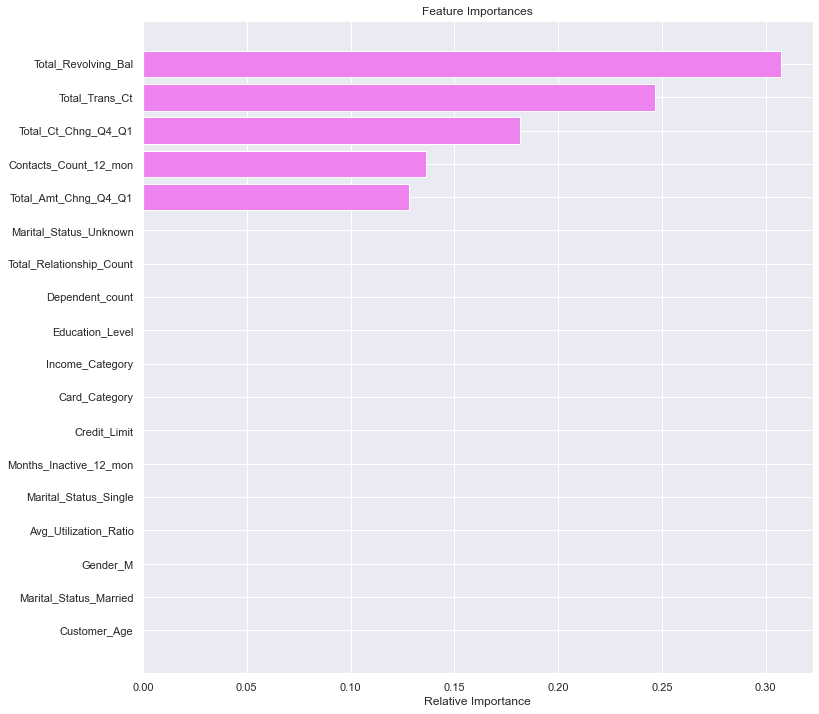

<IPython.core.display.Javascript object>

In [126]:
feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

* Total_Revolving_Bal, Total_Trans_Ct are the top 2 important features in the selected model
* Changes between Q4 and Q1 also show as important
* Contact_Count_12_mon hsows as the 4th most important feature from the model, however it showed significant impact on Attrition_Flag in EDA

## Build Production Pipeline

In [127]:
# creating a list of features for scaling
mm_scale_features = [
    "Customer_Age",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Total_Trans_Ct",
]

# MinMax Transformer for select features
mm_scale_transformer = Pipeline(steps=[("minmax", MinMaxScaler())])

# creating a list of categorical variables
ohe_features = ["Gender", "Marital_Status"]

# OHE Transformer for select categorical features
ohe_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# handle_unknown = "ignore", allows model to handle any unknown category in the test data

# combining categorical transformer and numerical transformer using a column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("scale", mm_scale_transformer, mm_scale_features),
        ("ohe", ohe_transformer, ohe_features),
    ],
    remainder="passthrough",
)
# remainder = "passthrough" has been used, it will allow variables that are present in original data
# but not in "numerical_columns" and "categorical_columns" to pass through the column transformer without any changes

<IPython.core.display.Javascript object>

In [128]:
Xp = bc_final.drop(["Attrition_Flag"], axis=1)
yp = bc_final["Attrition_Flag"]

<IPython.core.display.Javascript object>

In [129]:
# Splitting the data into train and test sets
Xp_train, Xp_test, yp_train, yp_test = train_test_split(
    Xp, yp, test_size=0.30, random_state=2021, stratify=yp
)
print(Xp_train.shape, Xp_test.shape)

(7088, 16) (3039, 16)


<IPython.core.display.Javascript object>

In [130]:
# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "XGB",
            XGBClassifier(
                random_state=2021,
                n_estimators=30,
                scale_pos_weight=15,
                gamma=3,
                subsample=1,
                learning_rate=0.1,
                eval_metric="logloss",
                max_depth=1,
                reg_lambda=10,
            ),
        ),
    ]
)
# Fit the model on training data
model.fit(Xp_train, yp_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  ['Customer_Age',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Total_Trans_Ct']),
                                                 ('ohe',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender',
                                                   'Marital_Status'])])),
                ('XGB',
            

<IPython.core.display.Javascript object>

## Insights and Recommendations
* Account activity seems to play a critical role in identifying customers who are at risk of Attiring, finding ways to incite customers to use their card more often could reduce churn. 
* Customers who have higher contact rates are more likely to attire, it is possible that the bank is actually identifying at risk customers earlier but are not successful in their outreach. Consider revising outreach protocols once churn customers are identified.
* The Silver card category has the lowest attrition rate, consider offering low activity Blue card customers an upgrade with incentives to use, such as rewards.
* There is no attrition for customers with total trans amounts > ~11,000 and few between 2700 and 5200, consider researching these customers further to determine the reason.
* Total_Revolving_Bal, Total_Trans_Ct are the top 2 important features in the selected model
    * Nearly all customers with a revolving balance < 500 attired, most of those have a Total transaction amount of < 3000
    * Nearly all customers with a 0 revolving balance attired
* For Months_on book, there is very high spike, nearly 25% of customers, at 36 months (3 years), consider researching why this may be so.  